# ADP 실기 25회 머신러닝
## 제품 주문 데이터 : 군집분석(K-means, DBSCAN)
    - InvoiceNo : 주문번호. ('C'로 시작하는 것은 취소 주문)
    - StockCode : 제품코드(Item Code)
    - Description : 제품 설명
    - Quantity : 주문 제품 건수
    - InvoiceDate : 주문 일자
    - UnitPrice : 제품 단가
    - CustomerID : 고객 번호
    - Country : 국가명(주문 고객의 국적)
- 1-1) F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 탐색적 분석 실시
- 1-2) F, M feature 기반으로 군집분석 실시, 필요시 이상값 보정
- 1-3) 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술
- 1-4) 적합된 군집 별 특성에 대한 의견과 비즈니스적 판단 제시

## 관광지 매달 평균 이용객 : 시계열 SARIMA
각 row는 관광지 A의 1990년 1월 부터 25년동안의 매달 평균 이용객 숫자
- 2-1) EDA와 시각화를 진행하라.
- 2-2) 결측치 처리와 해당 결측치 처리 방식에 대한 논리적 근거를 제시하라.
- 2-3) 계절성을 반영한 시계열 모델을 제시하고 정확도 측면에서 모델 성능 평가 할 것
- 2-4) 분석결과 활용 가능 여부에 대한 분석 전문가로서의 제안

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore")

# < 1. 군집분석 > 

In [3]:
import pandas as pd

df_customer = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem1.csv')
df_customer.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,565857,84879,ASSORTED COLOUR BIRD ORNAMENT,16,9/7/2011 14:13,1.69,14911.0,EIRE
1,560452,22432,WATERING CAN PINK BUNNY,6,7/19/2011 9:51,1.95,12682.0,France
2,578509,22492,MINI PAINT SET VINTAGE,36,11/24/2011 13:17,0.65,12705.0,Germany
3,579345,22728,ALARM CLOCK BAKELIKE PINK,8,11/29/2011 11:46,3.75,12727.0,France
4,564039,21731,RED TOADSTOOL LED NIGHT LIGHT,12,8/22/2011 12:40,1.65,12645.0,Germany


### 시계열 칼럼 맨 앞으로

In [4]:
df_customer.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
df_customer = df_customer[['InvoiceDate', 'InvoiceNo', 'StockCode', 
                           'Description', 'Quantity', 'UnitPrice', 'CustomerID', 
                           'Country']].copy()
df_customer

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,9/7/2011 14:13,565857,84879,ASSORTED COLOUR BIRD ORNAMENT,16,1.69,14911.0,EIRE
1,7/19/2011 9:51,560452,22432,WATERING CAN PINK BUNNY,6,1.95,12682.0,France
2,11/24/2011 13:17,578509,22492,MINI PAINT SET VINTAGE,36,0.65,12705.0,Germany
3,11/29/2011 11:46,579345,22728,ALARM CLOCK BAKELIKE PINK,8,3.75,12727.0,France
4,8/22/2011 12:40,564039,21731,RED TOADSTOOL LED NIGHT LIGHT,12,1.65,12645.0,Germany
...,...,...,...,...,...,...,...,...
41019,7/19/2011 15:55,560590,21884,CAKES AND BOWS GIFT TAPE,12,0.65,12560.0,Germany
41020,7/31/2011 11:45,561870,21156,RETROSPOT CHILDRENS APRON,8,1.95,14911.0,EIRE
41021,11/30/2011 15:43,579792,22436,12 COLOURED PARTY BALLOONS,20,0.65,12714.0,France
41022,9/14/2011 15:48,C566753,22796,PHOTO FRAME 3 CLASSIC HANGING,-1,9.95,14911.0,EIRE


In [6]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41024 entries, 0 to 41023
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceDate  41024 non-null  object 
 1   InvoiceNo    41024 non-null  object 
 2   StockCode    41024 non-null  object 
 3   Description  41024 non-null  object 
 4   Quantity     41024 non-null  int64  
 5   UnitPrice    41024 non-null  float64
 6   CustomerID   41024 non-null  float64
 7   Country      41024 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 2.5+ MB


In [7]:
df_customer.describe()

,Quantity,UnitPrice,CustomerID
count,41024.000000,41024.000000,41024.000000
mean,19.425507,4.652498,13173.076102
std,44.253624,45.383856,1006.392842
min,-480.000000,0.000000,12348.000000
25%,4.000000,1.250000,12484.000000
50%,10.000000,1.950000,12647.000000
75%,16.000000,3.750000,14156.000000
max,2400.000000,4161.060000,17097.000000


In [8]:
tmp = df_customer[df_customer['Quantity']<0]
tmp

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
32,10/24/2011 13:57,C572488,22972,CHILDREN'S SPACEBOY MUG,-1,1.65,12474.0,Germany
49,10/24/2011 13:43,C572479,37449,CERAMIC CAKE STAND + HANGING CAKES,-1,9.95,12463.0,Belgium
52,12/17/2010 12:58,C539409,POST,POSTAGE,-1,18.00,12720.0,Germany
175,5/24/2011 17:30,C554531,72741,GRAND CHOCOLATECANDLE,-2,1.45,12463.0,Belgium
184,3/24/2011 11:06,C547582,23177,TREASURE ISLAND BOOK BOX,-2,2.25,12474.0,Germany
...,...,...,...,...,...,...,...,...
40930,12/9/2010 15:41,C538123,22333,RETROSPOT PARTY BAG + STICKER SET,-1,1.65,12605.0,Germany
40958,10/27/2011 13:45,C573037,22423,REGENCY CAKESTAND 3 TIER,-11,10.95,12471.0,Germany
40986,10/12/2011 13:15,C570828,90202D,PINK ENAMEL FLOWER HAIR TIE,-6,2.95,14911.0,EIRE
40993,2/4/2011 9:46,C543175,POST,POSTAGE,-1,18.00,12712.0,Germany


In [9]:
tmp[tmp['InvoiceNo'].str[:1] != 'C']

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country


- 기술통계량 결과에서 Quantity의 min 값이 음수인 것을 확인 
    - 그런데 InvocieNo를 보면 맨 앞에 'C'가 붙어있다. 이는 취소(Cancel)를 나타내므로 Quantity의 음수 값이 합당해 보인다.
    - 단, Quantity가 음수인데, InvoiceNo에 'C'가 붙어있지 않은 obs.는 적절하지 않다고 판단한다. 그러나 이러한 데이터는 없었다.

In [10]:
df_customer.isnull().sum()            # 칼럼별 결측치 확인

InvoiceDate    0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [11]:
df_customer.shape       # 데이터 행,열 확인

(41024, 8)

In [12]:
df_customer[df_customer['InvoiceNo'] == '565857']

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,9/7/2011 14:13,565857,84879,ASSORTED COLOUR BIRD ORNAMENT,16,1.69,14911.0,EIRE
124,9/7/2011 14:13,565857,22842,BISCUIT TIN VINTAGE RED,2,6.75,14911.0,EIRE
558,9/7/2011 14:13,565857,21915,RED HARMONICA IN BOX,12,1.25,14911.0,EIRE
796,9/7/2011 14:13,565857,22993,SET OF 4 PANTRY JELLY MOULDS,12,1.25,14911.0,EIRE
968,9/7/2011 14:13,565857,82486,3 DRAWER ANTIQUE WHITE WOOD CABINET,2,8.95,14911.0,EIRE
...,...,...,...,...,...,...,...,...
38056,9/7/2011 14:13,565857,23054,RECYCLED ACAPULCO MAT LAVENDER,2,8.25,14911.0,EIRE
38517,9/7/2011 14:13,565857,22821,GIFT BAG PSYCHEDELIC APPLES,12,0.65,14911.0,EIRE
38975,9/7/2011 14:13,565857,21918,SET 12 KIDS COLOUR CHALK STICKS,24,0.42,14911.0,EIRE
40476,9/7/2011 14:13,565857,21672,WHITE SPOT RED CERAMIC DRAWER KNOB,12,1.45,14911.0,EIRE


In [13]:
df_customer[df_customer['InvoiceNo'] == '579792']

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
1069,11/30/2011 15:43,579792,21914,BLUE HARMONICA IN BOX,12,1.25,12714.0,France
1284,11/30/2011 15:43,579792,20676,RED RETROSPOT BOWL,8,1.25,12714.0,France
2516,11/30/2011 15:43,579792,22328,ROUND SNACK BOXES SET OF 4 FRUITS,6,2.95,12714.0,France
3866,11/30/2011 15:43,579792,22558,CLOTHES PEGS RETROSPOT PACK 24,12,1.65,12714.0,France
4269,11/30/2011 15:43,579792,22818,CARD CHRISTMAS VILLAGE,12,0.42,12714.0,France
...,...,...,...,...,...,...,...,...
39680,11/30/2011 15:43,579792,22635,CHILDS BREAKFAST SET DOLLY GIRL,6,9.95,12714.0,France
40265,11/30/2011 15:43,579792,23477,WOODLAND LARGE BLUE FELT HEART,12,1.25,12714.0,France
40345,11/30/2011 15:43,579792,23474,WOODLAND SMALL BLUE FELT HEART,12,0.83,12714.0,France
40482,11/30/2011 15:43,579792,23209,LUNCH BAG VINTAGE DOILY,10,1.65,12714.0,France


- InvoiceNo가 같으면 InvoiceDate가 같다. 
    - 즉, 유니크한 InvoiceNo마다 유저별로 1회의 구매빈도로 측정한다.

In [14]:
# 총 거래 횟수
print('총 거래 횟수: ', len( df_customer['InvoiceNo'].unique()))

# 총 유저 수
print('총 유저 수: ', len( df_customer['CustomerID'].unique()))
print('\n')

총 거래 횟수:  2111
총 유저 수:  348




## 1-1) F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 탐색적 분석 실시

In [15]:
# 소비자별 구매 빈도 피쳐

# as_index: 인덱스를 따로 만들지 않고 컬럼으로(False일때)
# nunique: 유니크한 value 갯수
customer_Freq = df_customer.groupby('CustomerID', as_index=False)[['InvoiceNo']].nunique( )  
customer_Freq.columns = ['CustomerID', 'Freq']
customer_Freq

,CustomerID,Freq
0,12348.0,4
1,12349.0,1
2,12350.0,1
3,12352.0,11
4,12354.0,1
...,...,...
343,14935.0,1
344,14936.0,9
345,14937.0,4
346,16321.0,7


In [16]:
# M (소비자별 총 구매액) 피쳐 생성

df_customer['M'] = df_customer['Quantity'] * df_customer['UnitPrice'] 
df_customer

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,M
0,9/7/2011 14:13,565857,84879,ASSORTED COLOUR BIRD ORNAMENT,16,1.69,14911.0,EIRE,27.04
1,7/19/2011 9:51,560452,22432,WATERING CAN PINK BUNNY,6,1.95,12682.0,France,11.70
2,11/24/2011 13:17,578509,22492,MINI PAINT SET VINTAGE,36,0.65,12705.0,Germany,23.40
3,11/29/2011 11:46,579345,22728,ALARM CLOCK BAKELIKE PINK,8,3.75,12727.0,France,30.00
4,8/22/2011 12:40,564039,21731,RED TOADSTOOL LED NIGHT LIGHT,12,1.65,12645.0,Germany,19.80
...,...,...,...,...,...,...,...,...,...
41019,7/19/2011 15:55,560590,21884,CAKES AND BOWS GIFT TAPE,12,0.65,12560.0,Germany,7.80
41020,7/31/2011 11:45,561870,21156,RETROSPOT CHILDRENS APRON,8,1.95,14911.0,EIRE,15.60
41021,11/30/2011 15:43,579792,22436,12 COLOURED PARTY BALLOONS,20,0.65,12714.0,France,13.00
41022,9/14/2011 15:48,C566753,22796,PHOTO FRAME 3 CLASSIC HANGING,-1,9.95,14911.0,EIRE,-9.95


In [17]:
# 소비자별 구매액 데이터 프레임

customer_amount = df_customer.groupby('CustomerID', as_index=False)[['M']].sum()
customer_amount 

,CustomerID,M
0,12348.0,1797.24
1,12349.0,1757.55
2,12350.0,334.40
3,12352.0,1545.41
4,12354.0,1079.40
...,...,...
343,14935.0,1784.71
344,14936.0,8117.42
345,14937.0,1617.63
346,16321.0,230.70


In [18]:
# 데이터프레임 결합
df_F_M = pd.merge(customer_Freq, customer_amount,
                           how='left',
                           left_on='CustomerID',
                           right_on='CustomerID')
df_F_M

,CustomerID,Freq,M
0,12348.0,4,1797.24
1,12349.0,1,1757.55
2,12350.0,1,334.40
3,12352.0,11,1545.41
4,12354.0,1,1079.40
...,...,...,...
343,14935.0,1,1784.71
344,14936.0,9,8117.42
345,14937.0,4,1617.63
346,16321.0,7,230.70


### 소비자별 구매 빈도 & 소비자별 총 구매액 분포 확인

<AxesSubplot:xlabel='M', ylabel='Density'>

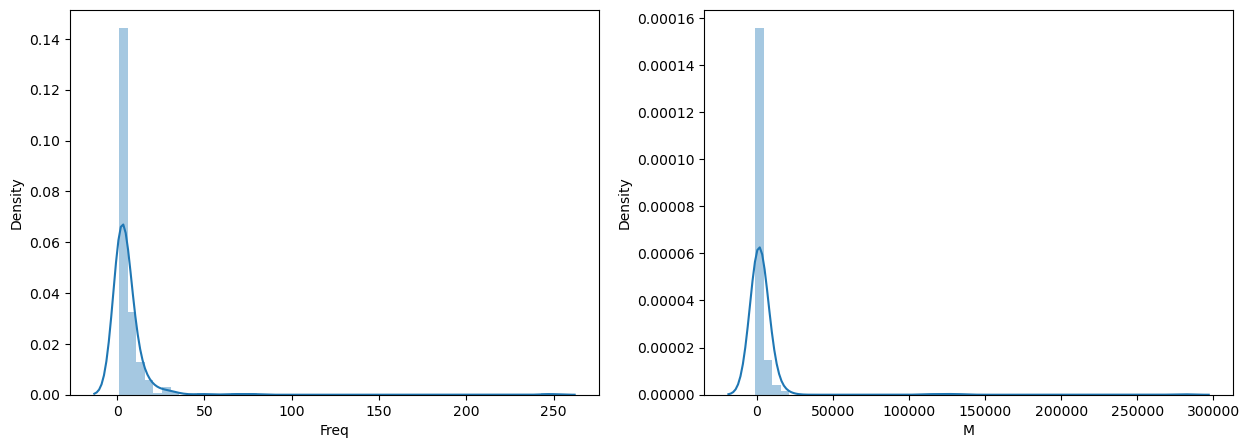

In [19]:
plt.figure(figsize=(15,5))

plt.subplot(121)
sns.distplot(df_F_M['Freq'])

plt.subplot(122)
sns.distplot(df_F_M['M'])

#### F, M 간의 Scale 차이가 커서 Scaling이 필요해 보인다.
#### 또한 추후 진행할 군집분석은 변수 간의 상대적인 크기나 분포에 영향을 받을 수 있으므로 스케일링이 필요하다.
- 군집분석은 주어진 데이터를 클러스터로 그룹화하는 비지도 학습 기법

### 소비자별 구매 빈도 & 소비자별 총 구매액 통계량

In [20]:
df_F_M[df_F_M.columns[1:]].describe()

,Freq,M
count,348.000000,348.000000
mean,6.066092,3960.727356
std,15.155437,18821.144519
min,1.000000,-1126.000000
25%,1.000000,452.000000
50%,3.000000,1008.990000
75%,6.000000,2760.185000
max,248.000000,279489.020000


#### 소비자들은 평균적으로 6번으로 구매하고, $3,960 금액만큼 구매한다.

### Boxplot을 통한 이상치 탐색

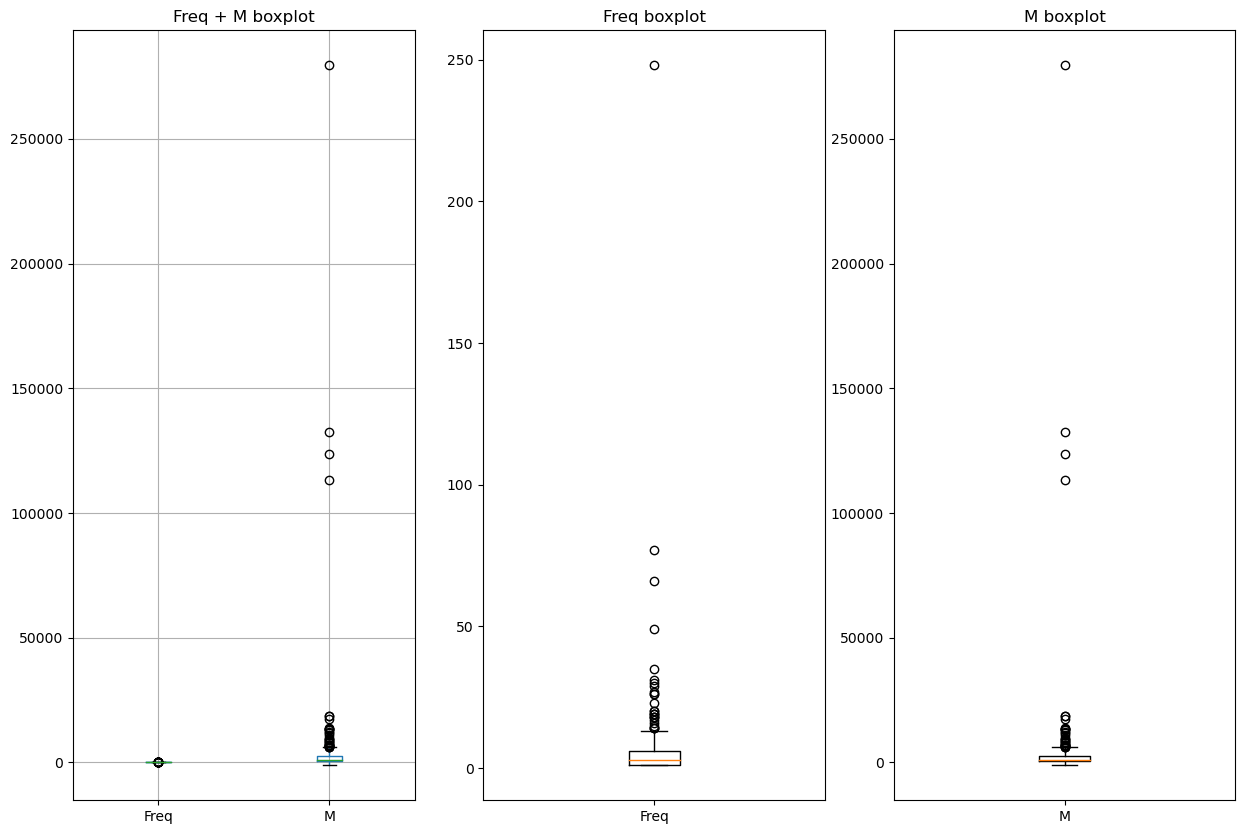

In [21]:
plt.figure(figsize=(15,10))

plt.subplot(131)
df_F_M[['Freq', 'M']].boxplot()
plt.title('Freq + M boxplot')

plt.subplot(132)
plt.boxplot(df_F_M['Freq'].values)
plt.xticks([1], ['Freq'])
plt.title('Freq boxplot')

plt.subplot(133)
plt.boxplot(df_F_M['M'].values)
plt.xticks([1], ['M'])
plt.title('M boxplot')

plt.show()

#### boxplot을 그려본 결과 이상치가 많아, 이상치 제거가 필요해 보인다.

## 1-2) F, M Feature 기반으로 군집분석 실시 (필요시 이상치 제거 및 변환을 적용하라) => 이상치 제거 및 Scaling(변환)이 핵심

### 스케일링

다른 변수들과 큰 차이가 없으려면 RobustScaler가 제일 적절해 보임 (StandardScaler로 가능함)

|순서|종류|설명|
|-|---------------|------------------------|
|1|StandardScaler|기본 스케일. 평균과 표준편차 사용|
|2|MinMaxScaler|최대/최소값이 각각 1, 0이 되도록 스케일링|
|3|MaxAbsScaler|최대절대값과 0이 각각 1, 0이 되도록 스케일링|
|4|RobustScaler|중앙값(median)과 IQR(interquartile range) 사용. 아웃라이어의 영향을 최소화|

In [22]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

df_F_M_scaled = pd.DataFrame(scaler.fit_transform(df_F_M[['Freq', 'M']]),
                                          columns=['Scaled_Freq', 'Scaled_M'])
ㅠ
df_F_M_scaled.insert(0, 'CustomerID', df_F_M['CustomerID'])
df_F_M_scaled 

NameError: name 'ᅲ' is not defined

<AxesSubplot:>

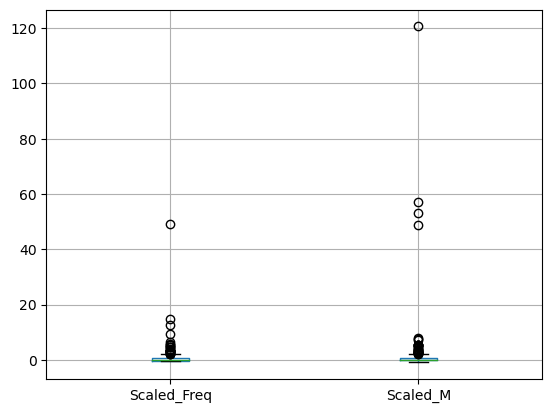

In [23]:
# 스케일 확인

df_F_M_scaled[['Scaled_Freq', 'Scaled_M']].boxplot()

### 사분위수를 활용한 이상치 제거
- 통계적인 방법으로 Q1(제1사분위수)-1.5*IQR(사분범위) 보다 작거나 Q3(제3사분위수)+1.5*IQR(사분범위)보다 큰 이상치는 제거

In [24]:
# 이상치 제거 함수

def remove_out(dataframe, remove_col):

    df = dataframe.copy()
    print('original_df :', len(df))

    for k in remove_col:
        level_1q = df[k].quantile(0.25)  # 제 1사분위수
        level_3q = df[k].quantile(0.75)  # 제 3사분위수
        
        IQR = level_3q - level_1q         # 사분위범위
        rev_range = 1.5                   # 제거 범위 조절 변수
        
        df = df[ (df[k] >= level_1q - (rev_range * IQR)) \
                & (df[k] <= level_3q + (rev_range * IQR)) ] # 이상치 제거하고 남기기
        df = df.reset_index(drop=True)      # 이상치 제거 후, index reset

    
    print('IQR_df :', len(df))
    print()
    return df

In [25]:
# 이상치 제거 한 데이터프레임
df_F_M_scaled_rm_outlier = remove_out(df_F_M_scaled, 
                                      ['Scaled_Freq','Scaled_M'])
df_F_M_scaled_rm_outlier

original_df : 348
IQR_df : 298



,Scaled_Freq,Scaled_M
0,0.2,0.341502
1,-0.4,0.324307
2,-0.4,-0.292260
3,1.6,0.232399
4,-0.4,0.030504
...,...,...
293,0.0,0.381187
294,-0.4,0.336074
295,0.2,0.263688
296,0.8,-0.337187


(-2.0, 3.0)

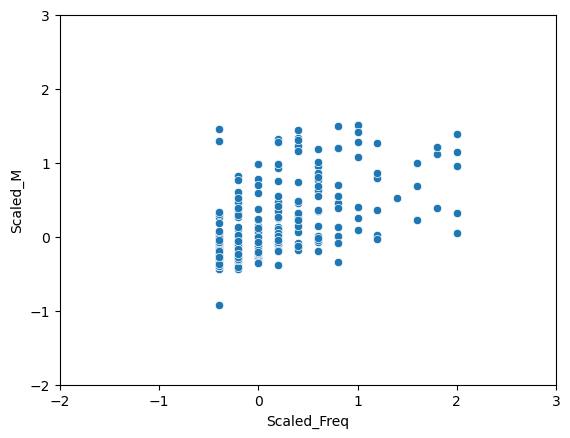

In [26]:
sns.scatterplot(x='Scaled_Freq', y='Scaled_M', data=df_F_M_scaled_rm_outlier)
plt.xlim(-2,3)
plt.ylim(-2,3)

In [27]:
# 군집분석에 사용할 df

clu_df = df_F_M_scaled_rm_outlier[['Scaled_Freq','Scaled_M']]

### 군집분석 k 결정
군집의 개수 k를 미리 정해주어야 하는 알고리즘에서 군집의 개수 k를 결정하고 선택하는 데 도움을 받을 수 있는 3가지 방법
- Hierarchical Clustering(계층적 군집분석 -> Dendrogram(덴드로그램) 시각화)
- Elbow Method
- The Silhouette Method
  
=> 이 문제에서 위의 3가지 방법 모두 사용 가능
   하지만 문제에서 굳이 "군집 내 응집도, 군집 간 분리도 개념"을 사용해서 서술하라고 했으므로, 이때 설명하기 쉬운 Silhouette Method가 적절해 보인다

### 실루엣 계수 특징 및 해석 방법
- 개별 데이터가 가지는 군집화 지표
- **해당 데이터가 같은 군집 내 데이터와 얼마나 가깝게 군집화 돼있고, 다른 군집에 있는 데이터와는 얼마나 멀리 분리돼있는지를 나타내는 지표**
    - 군집 내 응집도와 군집 간 분리도를 이용한 지표
- 실루엣 계수는 -1 과 1 사이

결과해석 방법
- 실루엣 계수의 전체 평균 값이 크고 + 클러스터'별' 실루엣 계수 평균 값이 클수록 클러스터링이 잘 되었다고 판단
- **개별 군집의 평균값 편차가 크지 않아야함**
    - 개별 군집의 평균값 편차가 크다면 좋은 군집화 조건이 아님
    - 개별 군집의 평균 실루엣 계수값 편차가 크다는 것은 군집들 간에 실루엣 계수의 차이가 크다는 것을 의미
    - 이 경우, 군집화가 일관성이 없거나 군집 내부의 데이터들이 서로 다른 조밀성을 가지고 있다는 것을 나타낼 수 있음
    - 평균 실루엣 계수값 편차가 큰 경우, 군집화 결과가 상이한 특징을 가지는 군집들이 포함되어 있을 가능성이 있음
    - 이는 군집화의 일관성이 떨어진다는 것을 의미
    - 따라서 군집화의 일관성을 평가하는 관점에서는 평균 실루엣 계수값 편차가 작은 것이 좋은 군집화 조건으로 간주됩니다.
- 실루엣 값이 1에 가까우면, 다른 군집과의 거리보다 동일 군집 내 객체 간 거리가 가깝다는 뜻 => 객체 i가 잘 군집화가 되었다는 의미
- 실루엣 값이 -1에 가까우면 객체 i의 군집화가 잘못되었다는 의미
- 많은 객체들이 낮거나 혹은 음(-)의 실루엣 값을 가진다면 군집 구성이 너무 많거나 또는 너무 적은 수의 군집을 가졌기 때문이라고 판단할 수 있음
- 그래프 상에서는 클러스터 내의 데이터 포인트별로 실루엣 계수 1에 가까울수록 + 값이 급격히 감소하지 않을수록 좋다.(그래프의 경사를 보면 됨)

장점 
- 클러스터링이 수행된 후 실제 구분된 클러스터에 따라 실루엣 계수를 구하기 때문에, 클러스터링 알고리즘에 영향을 받지 않는다. 
- 적절한 클러스터 개수를 정하거나 더 나은 클러스터링 기법을 선택하는 기준으로 삼을 수 있다. 
- 클러스터링 결과 값을 시각화할 수 있다. 
단점
- 데이터 양이 많아질수록 수행 시간이 오래 걸린다.


### 최적의 군집 개수를 판단하는 방법 : 엘보우 기법
- 클러스터 내 오차제곱합(SSE)를 클러스터 개수마다 비교하는 방법
- 클러스터 개수를 늘려나가면서 계산한 SSE를 비교
- 군집 개수 K개에 따른 오차제곱합을 시각화하여, 오차제곱합이 평평해지기 시작하는 지점(=팔꿈치, elbow)을 K로 지정
- 개수가 늘 때마다 평균값이 급격히 감소하는데 적절한 K가 발견되면 매우 천천히 감소한다.

In [31]:
# 최적 군집 개수 탐색
from sklearn.cluster import KMeans

def elbow(X):
    sse=[]
    for i in range(1, 11):
        km = KMeans(n_clusters=i, random_state=1)
        km.fit(X)
        sse.append(km.inertia_)
    
    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('The Number of Clusters')
    plt.ylabel('SSE')
    plt.show()
    print(sse)

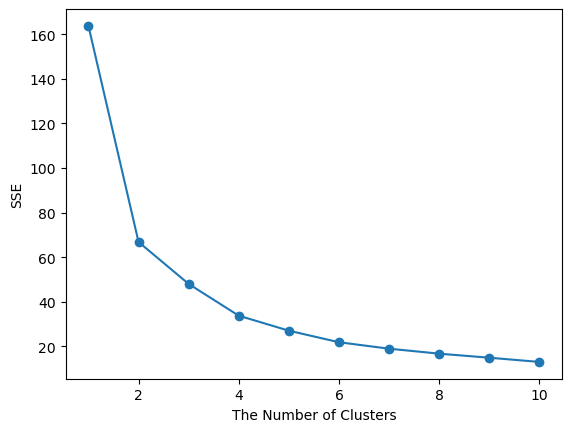

[163.76760172392355, 66.8002776862798, 47.978417265212215, 33.72643380593394, 26.9990028174046, 21.810087919513933, 18.9160404973681, 16.681866008877627, 14.863976132025957, 12.97575443999157]


In [32]:
elbow(clu_df)

####  엘보우 기법을 적용해, 먼저 군집을 4개로 선정하여 군집분석 진행
#### 각각 3개, 4개, 5개의 군집으로 군집분석을 실시한 후 실루엣 분석을 통해, 최종 군집 개수를 선정한다.

### 군집개수 3개

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score 

# 학습
# k = 3 일때 k-means clustering 객체 생성
# init = random 옵션 : 군집 초기화를 random으로 한다. 
# default=K++로 이는 수렴에 빠르게 해주는 방법으로 한다고 함. 
# 즉 해당 파라미터는 안써도 무방
kmeans_3 = KMeans(n_clusters=3,
                  init = 'random', 
                  random_state = 2023)
kmeans_3.fit(clu_df)

df_F_M_scaled_rm_outlier["cluster"] = kmeans_3.labels_

# 평가
# 데이터 포인트 마다 실루엣 계수 구하기
cluster_3_silhouette_df = df_F_M_scaled_rm_outlier[['Scaled_Freq', 'Scaled_M']].copy()
score_samples = silhouette_samples(cluster_3_silhouette_df, 
                                   df_F_M_scaled_rm_outlier["cluster"])

print(score_samples.shape)

# 실루엣 계수 칼럼 추가
df_F_M_scaled_rm_outlier["silhouette_coef"]= score_samples

# 전체 데이터 평균 실루엣 계수 
average_score = silhouette_score(clu_df, 
                                 df_F_M_scaled_rm_outlier["cluster"])
print("실루엣 계수 평균:", average_score)

display(df_F_M_scaled_rm_outlier.head(3))

# 군집별 평균 실루엣 계수
df_F_M_scaled_rm_outlier.groupby("cluster")["silhouette_coef"].mean()

(298,)
실루엣 계수 평균: 0.45891581869350206


,Scaled_Freq,Scaled_M,cluster,silhouette_coef
0,0.2,0.341502,0,0.444156
1,-0.4,0.324307,2,0.182662
2,-0.4,-0.292260,2,0.765841


cluster
0    0.227997
1    0.257417
2    0.638444
Name: silhouette_coef, dtype: float64

(-2.0, 3.0)

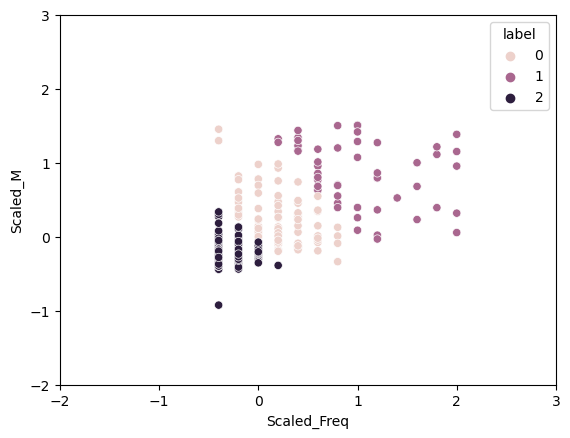

In [34]:
data_3 = pd.concat([df_F_M_scaled_rm_outlier, 
                    pd.DataFrame(kmeans_3.labels_, columns=['label'])], axis=1)

sns.scatterplot(x='Scaled_Freq', 
                y='Scaled_M', 
                hue='label',
                data = data_3)
plt.xlim(-2,3)
plt.ylim(-2,3)

### 군집개수 4개

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score 

# 학습
# k = 3 일때 k-means clustering 객체 생성
kmeans_4 = KMeans(n_clusters=4,
                  init = 'random',
                  random_state = 2023)
kmeans_4.fit(clu_df)

df_F_M_scaled_rm_outlier["cluster"] = kmeans_4.labels_

# 평가
# 데이터 포인트 마다 실루엣 계수 구하기
cluster_4_silhouette_df = df_F_M_scaled_rm_outlier[['Scaled_Freq', 'Scaled_M']].copy()

score_samples = silhouette_samples(cluster_4_silhouette_df,
                                   df_F_M_scaled_rm_outlier["cluster"])

print(score_samples.shape)

# 실루엣 계수 칼럼 추가
df_F_M_scaled_rm_outlier["silhouette_coef"]= score_samples

# 전체 데이터 평균 실루엣 계수 
average_score = silhouette_score(clu_df, 
                                 df_F_M_scaled_rm_outlier["cluster"])
print("실루엣 계수 평균:", average_score)

display(df_F_M_scaled_rm_outlier.head(3))

# 군집별 평균 실루엣 계수
df_F_M_scaled_rm_outlier.groupby("cluster")["silhouette_coef"].mean()

(298,)
실루엣 계수 평균: 0.469817620549594


,Scaled_Freq,Scaled_M,cluster,silhouette_coef
0,0.2,0.341502,2,0.483705
1,-0.4,0.324307,3,0.175507
2,-0.4,-0.292260,3,0.751047


cluster
0    0.330895
1    0.339164
2    0.291607
3    0.607163
Name: silhouette_coef, dtype: float64

(-2.0, 3.0)

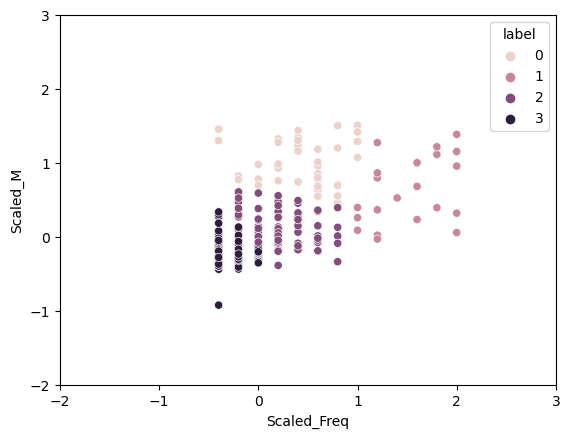

In [36]:
data_4 = pd.concat([df_F_M_scaled_rm_outlier, 
                    pd.DataFrame(kmeans_4.labels_, columns=['label'])], axis=1)

sns.scatterplot(x='Scaled_Freq', 
                y='Scaled_M', 
                hue='label',
                data = data_4)
plt.xlim(-2,3)
plt.ylim(-2,3)

### 군집개수 5개

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score 

# 학습
# k = 3 일때 k-means clustering 객체 생성
kmeans_5 = KMeans(n_clusters=5,
                  init = 'random', 
                  random_state = 2023)
kmeans_5.fit(clu_df)

df_F_M_scaled_rm_outlier["cluster"] = kmeans_5.labels_

# 평가
# 데이터 포인트 마다 실루엣 계수 구하기
cluster_5_silhouette_df = df_F_M_scaled_rm_outlier[['Scaled_Freq', 'Scaled_M']].copy()
score_samples = silhouette_samples(cluster_5_silhouette_df, 
                                   df_F_M_scaled_rm_outlier["cluster"])

print(score_samples.shape)

# 실루엣 계수 칼럼 추가
df_F_M_scaled_rm_outlier["silhouette_coef"]= score_samples

# 모든 데이터의 평균 실루엣 계수 구하기
average_score = silhouette_score(clu_df, 
                                 df_F_M_scaled_rm_outlier["cluster"]) 
print("실루엣 계수 평균:", average_score) 

display(df_F_M_scaled_rm_outlier.head(3))

df_F_M_scaled_rm_outlier.groupby("cluster")["silhouette_coef"].mean()

(298,)
실루엣 계수 평균: 0.42214954112041203


,Scaled_Freq,Scaled_M,cluster,silhouette_coef
0,0.2,0.341502,2,0.187715
1,-0.4,0.324307,2,0.133094
2,-0.4,-0.292260,4,0.759701


cluster
0    0.312230
1    0.374988
2    0.235549
3    0.286767
4    0.627063
Name: silhouette_coef, dtype: float64

(-2.0, 3.0)

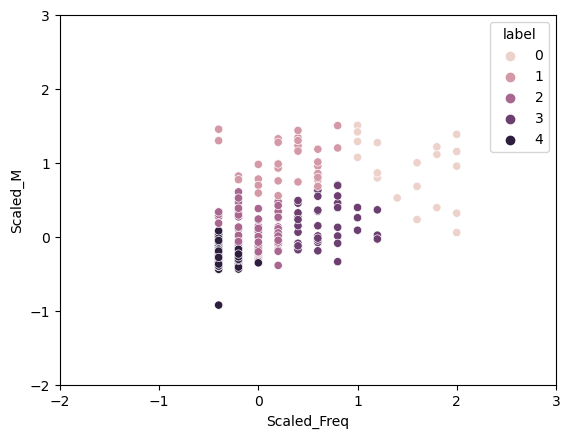

In [38]:
data_5 = pd.concat([df_F_M_scaled_rm_outlier, 
                    pd.DataFrame(kmeans_5.labels_, columns=['label'])], axis=1)

sns.scatterplot(x='Scaled_Freq', 
                y='Scaled_M', 
                hue='label',
                data = data_5)
plt.xlim(-2,3)
plt.ylim(-2,3)

## 1-3) 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술
$\rightarrow$ 실루엣 계수 !!

실루엣 계수
- 실루엣 계수는 군집 내 응집도와 군집 간 분리도를 이용하여, 해당 데이터가 같은 군집 내 데이터와 얼마나 가깝게 군집화 돼있고, 다른 군집에 있는 데이터와는 얼마나 멀리 분리돼있는지를 나타내는 지표이다.
- 실루엣 계수는 -1 과 1 사이의 값을 가지며 1에 가까울 수록 군집이 잘 되었다는 것을 의미한다.

개별 군집의 실루엣 계수 평균값 편차
- 또한 개별 군집의 평균값 편차가 크다면 좋은 군집화 조건이라고 할 수 없다. 
- 이 경우, 군집화가 일관성이 없거나 군집 내부의 데이터들이 서로 다른 조밀성을 가지고 있다는 것을 나타낼 수 있다. 
- 즉, 군집화의 일관성이 떨어진다는 것을 의미한다. 

#### 따라서 군집 갯수 k=3,4,5를 비교한 결과, 전체 평균 실루엣 값이 k=4일때 가장 높으므로 4개의 군집이 적절해 보인다. 
#### 또한 3, 5개의 군집으로 분석했을 때보다 4개의 군집으로 분석했을 경우가 개별 군집의 평균값 편차가 차이가 적으므로, 4개가 적절하다고 생각한다.


## 1-4) 적합된 군집 별 특성에 대한 의견과 비즈니스적 판단 제시

In [41]:
# 최종 군집 4개

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score 

# 학습
# k = 3 일때 k-means clustering 객체 생성
kmeans_4 = KMeans(n_clusters=4,
                  init = 'random',
                  random_state = 2023)
kmeans_4.fit(clu_df)

df_F_M_scaled_rm_outlier["cluster"] = kmeans_4.labels_

# 평가
# 데이터 포인트 마다 실루엣 계수 구하기
cluster_4_silhouette_df = df_F_M_scaled_rm_outlier[['Scaled_Freq', 'Scaled_M']].copy()

score_samples = silhouette_samples(cluster_4_silhouette_df,
                                   df_F_M_scaled_rm_outlier["cluster"])

print(score_samples.shape)

# 실루엣 계수 칼럼 추가
df_F_M_scaled_rm_outlier["silhouette_coef"]= score_samples

(298,)


In [42]:
df_F_M_scaled_rm_outlier

,Scaled_Freq,Scaled_M,cluster,silhouette_coef
0,0.2,0.341502,2,0.483705
1,-0.4,0.324307,3,0.175507
2,-0.4,-0.292260,3,0.751047
3,1.6,0.232399,1,0.519692
4,-0.4,0.030504,3,0.519532
...,...,...,...,...
293,0.0,0.381187,2,0.333390
294,-0.4,0.336074,3,0.163535
295,0.2,0.263688,2,0.494660
296,0.8,-0.337187,2,0.306400


### 원래 F, M 데이터 프레임에 cluster 별 describe/mean 비교

In [44]:
df_F_M_scaled_rm_outlier.groupby("cluster").mean()

,Scaled_Freq,Scaled_M,silhouette_coef
cluster,,,
0,0.460000,1.011081,0.330895
1,1.500000,0.629861,0.339164
2,0.231579,0.112052,0.291607
3,-0.291250,-0.223517,0.607163


소비자별 구매 빈도(F) & 소비자별 총 구매액(M)

#### 0번 군집의 경우 소비자별 총 구매액이 가장 많은 것으로 보인다.
- 이 군집의 고객들을 대상으로 고객 서비스 개선, 맞춤형 마케팅 전략, 혜택 및 할인 프로그램 등을 추진하는 것이 유리할 수 있다. 
- 이를 통해 이 군집의 고객들과의 유지 및 확장을 도모할 수 있다.

#### 3번 군집의 경우 소비자별 구매 빈도와 소비자별 총 구매액이 모두 음수 값으로, 구매를 취소한 집단으로 보인다. 
- 구매를 취소한 집단은 실수로 구매를 취소한 경우일 수도 있고, 불만이나 불만족으로 인해 구매를 취소한 경우일 수도 있다. 
- 비즈니스적으로는 이러한 고객들의 취소 이유를 분석하고 원인을 해결하는 것이 중요하다. 
- 불만족한 고객들과의 개별적인 대화나 피드백 수집을 통해 문제점을 파악하고 개선점을 찾아야 한다.

#### 구매를 취소한 집단을 제외하고, 나머지 세 군집 중 2번 군집이 구매빈도와 총 구매액이 가장 낮은 것으로 보인다.
- 이 군집은 비교적 적은 가치를 창출하는 소비자 그룹으로 해석될 수 있다. 
- 해당 군집의 고객들에게 제품 또는 서비스에 대한 추가 가치를 제공하거나, 새로운 마케팅 접근법을 도입하여 잠재적인 구매 활동을 촉진할 수 있다. 
- 이 군집의 구매 행동을 분석하여 개별 고객의 요구사항과 선호도를 파악하고, 맞춤형 마케팅 전략을 구축하는 것이 유리할 수 있다.

---

# < 2. 시계열분석 : SARIMA >
각 row는 관광지 A의 1990년 1월 부터 25년동안의 매달 평균 이용객 숫자이다.
```
2-1) EDA와 시각화를 진행하라.
2-2) 결측치 처리와 해당 결측치 처리 방식에 대한 논리적 근거를 제시하라.
2-3) 계절성을 반영한 시계열 모델을 제시하고 정확도 측면에서 모델 성능 평가 할 것
2-4) 분석결과 활용 가능 여부에 대한 분석 전문가로서의 제안
```

## 본격 분석 전 데이터 생성

In [46]:
# 시계열
from scipy import interpolate  # 결측치 - 보간법

import statsmodels.api as sm                               
from statsmodels.tsa.arima.model import ARIMA              
from statsmodels.tsa.statespace.sarimax import SARIMAX     
from statsmodels.tsa.stattools import acf, pacf
import pmdarima as pm
from pmdarima.arima import auto_arima                      

# 시계열 시각화
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf   
from statsmodels.tsa.stattools import adfuller                        
import itertools

In [47]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem2.csv', 
                index_col = 0) # CSV 파일의 첫 번째 열을 인덱스로 설정하는 매개변수
df.head()

,counts
0,544.3
1,603.1
2,NaN
3,533.4
4,619.5


In [48]:
df.shape

(300, 1)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   counts  295 non-null    float64
dtypes: float64(1)
memory usage: 4.7 KB


- 각 row는 관광지 A의 1990년 1월 부터 25년동안의 매달 평균 이용객 숫자라고 명시되어있는데, 
- 시계열 인덱스가 없으므로 먼저 시계열 인덱스를 생성해준다.

- 시계열 데이터 생성방법
```python
pd.date_range(start, end, periods, freq) (periods는 그 수만큼 균등하게 나눠줌. freq는 아래 인자를 통해 생성됨)
```
    - freq 인수
        - s: 초
        - T: 분
        - H: 시간
        - D: 일(day)
        - B: 주말이 아닌 평일
        - W: 주(일요일)
        - W-MON: 주(월요일)
        - M: 각 달(month)의 마지막 날
        - MS: 각 달의 첫날
        - BM: 주말이 아닌 평일 중에서 각 달의 마지막 날
        - BMS: 주말이 아닌 평일 중에서 각 달의 첫날
        - WOM-2THU: 각 달의 두번째 목요일
        - Q-JAN: 각 분기의 첫달의 마지막 날
        - Q-DEC: 각 분기의 마지막 달의 마지막 날

In [50]:
date = pd.date_range("1990-01", 
                     "2014-12", 
                     freq='MS') # 각 달의 첫날
date

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', length=300, freq='MS')

In [51]:
# 데이터프레임에 열을 삽입하는 메서드
df.insert(0, # 0을 사용하여 첫 번째 열의 위치에 열을 삽입
          'date', # 삽입될 열의 이름
          date) # 열에 삽입될 데이터
df

,date,counts
0,1990-01-01,544.3
1,1990-02-01,603.1
2,1990-03-01,NaN
3,1990-04-01,533.4
4,1990-05-01,619.5
...,...,...
295,2014-08-01,445.2
296,2014-09-01,472.0
297,2014-10-01,341.6
298,2014-11-01,477.8


- 300행 모두 잘 생성됨을 확인

## 2-1) EDA와 시각화를 진행하라.

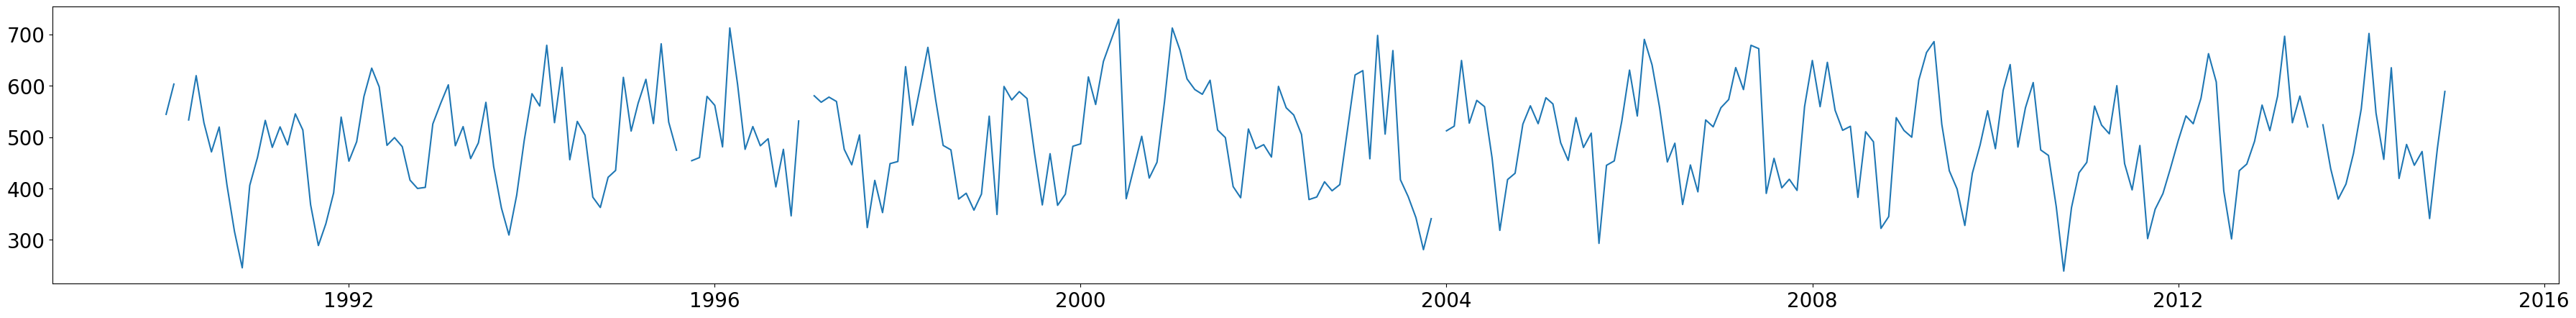

In [52]:
plt.figure(figsize=(45,5))

# 각각 x축과 y축의 눈금에 대한 설정을 변경
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

fig = plt.plot(df['date'], df['counts'])

<AxesSubplot:>

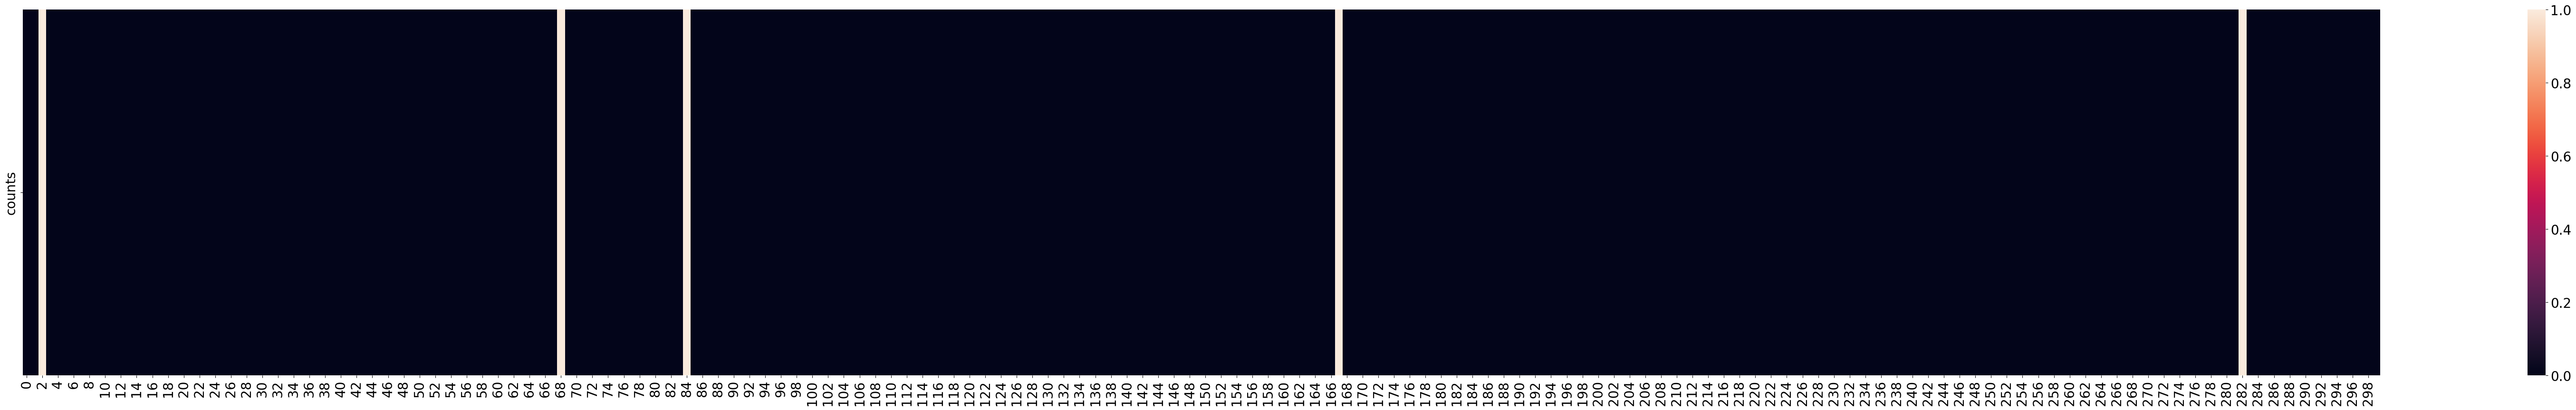

In [53]:
# 결측치 위치 파악
plt.figure(figsize=(80,10))
sns.heatmap(df[['counts']].isnull().T)

In [54]:
df[df['counts'].isnull()]

,date,counts
2,1990-03-01,NaN
68,1995-09-01,NaN
84,1997-01-01,NaN
167,2003-12-01,NaN
282,2013-07-01,NaN


## 2-2) 결측치 처리와 해당 결측치 처리 방식에 대한 논리적 근거를 제시하라.


In [55]:
df.isnull().sum()

date      0
counts    5
dtype: int64

- 결측치 탐색 결과 count 칼럼에 5개의 결측치가 존재함을 확인

### 시계열 데이터의 결측치 처리 방법
- 시계열 데이터의 결측치 처리 방법엔 대치법, 보간법, 이동평균법 등 다양한 방법이 존재
- 그 중 데이터의 비선형성을 잘 고려할 수 있는 cubic Interpolation을 선택하여 결측치를 처리

In [56]:
df['impute_cub_interpol'] = df['counts'].interpolate(method='cubic')
df

,date,counts,impute_cub_interpol
0,1990-01-01,544.3,544.300000
1,1990-02-01,603.1,603.100000
2,1990-03-01,NaN,543.513195
3,1990-04-01,533.4,533.400000
4,1990-05-01,619.5,619.500000
...,...,...,...
295,2014-08-01,445.2,445.200000
296,2014-09-01,472.0,472.000000
297,2014-10-01,341.6,341.600000
298,2014-11-01,477.8,477.800000


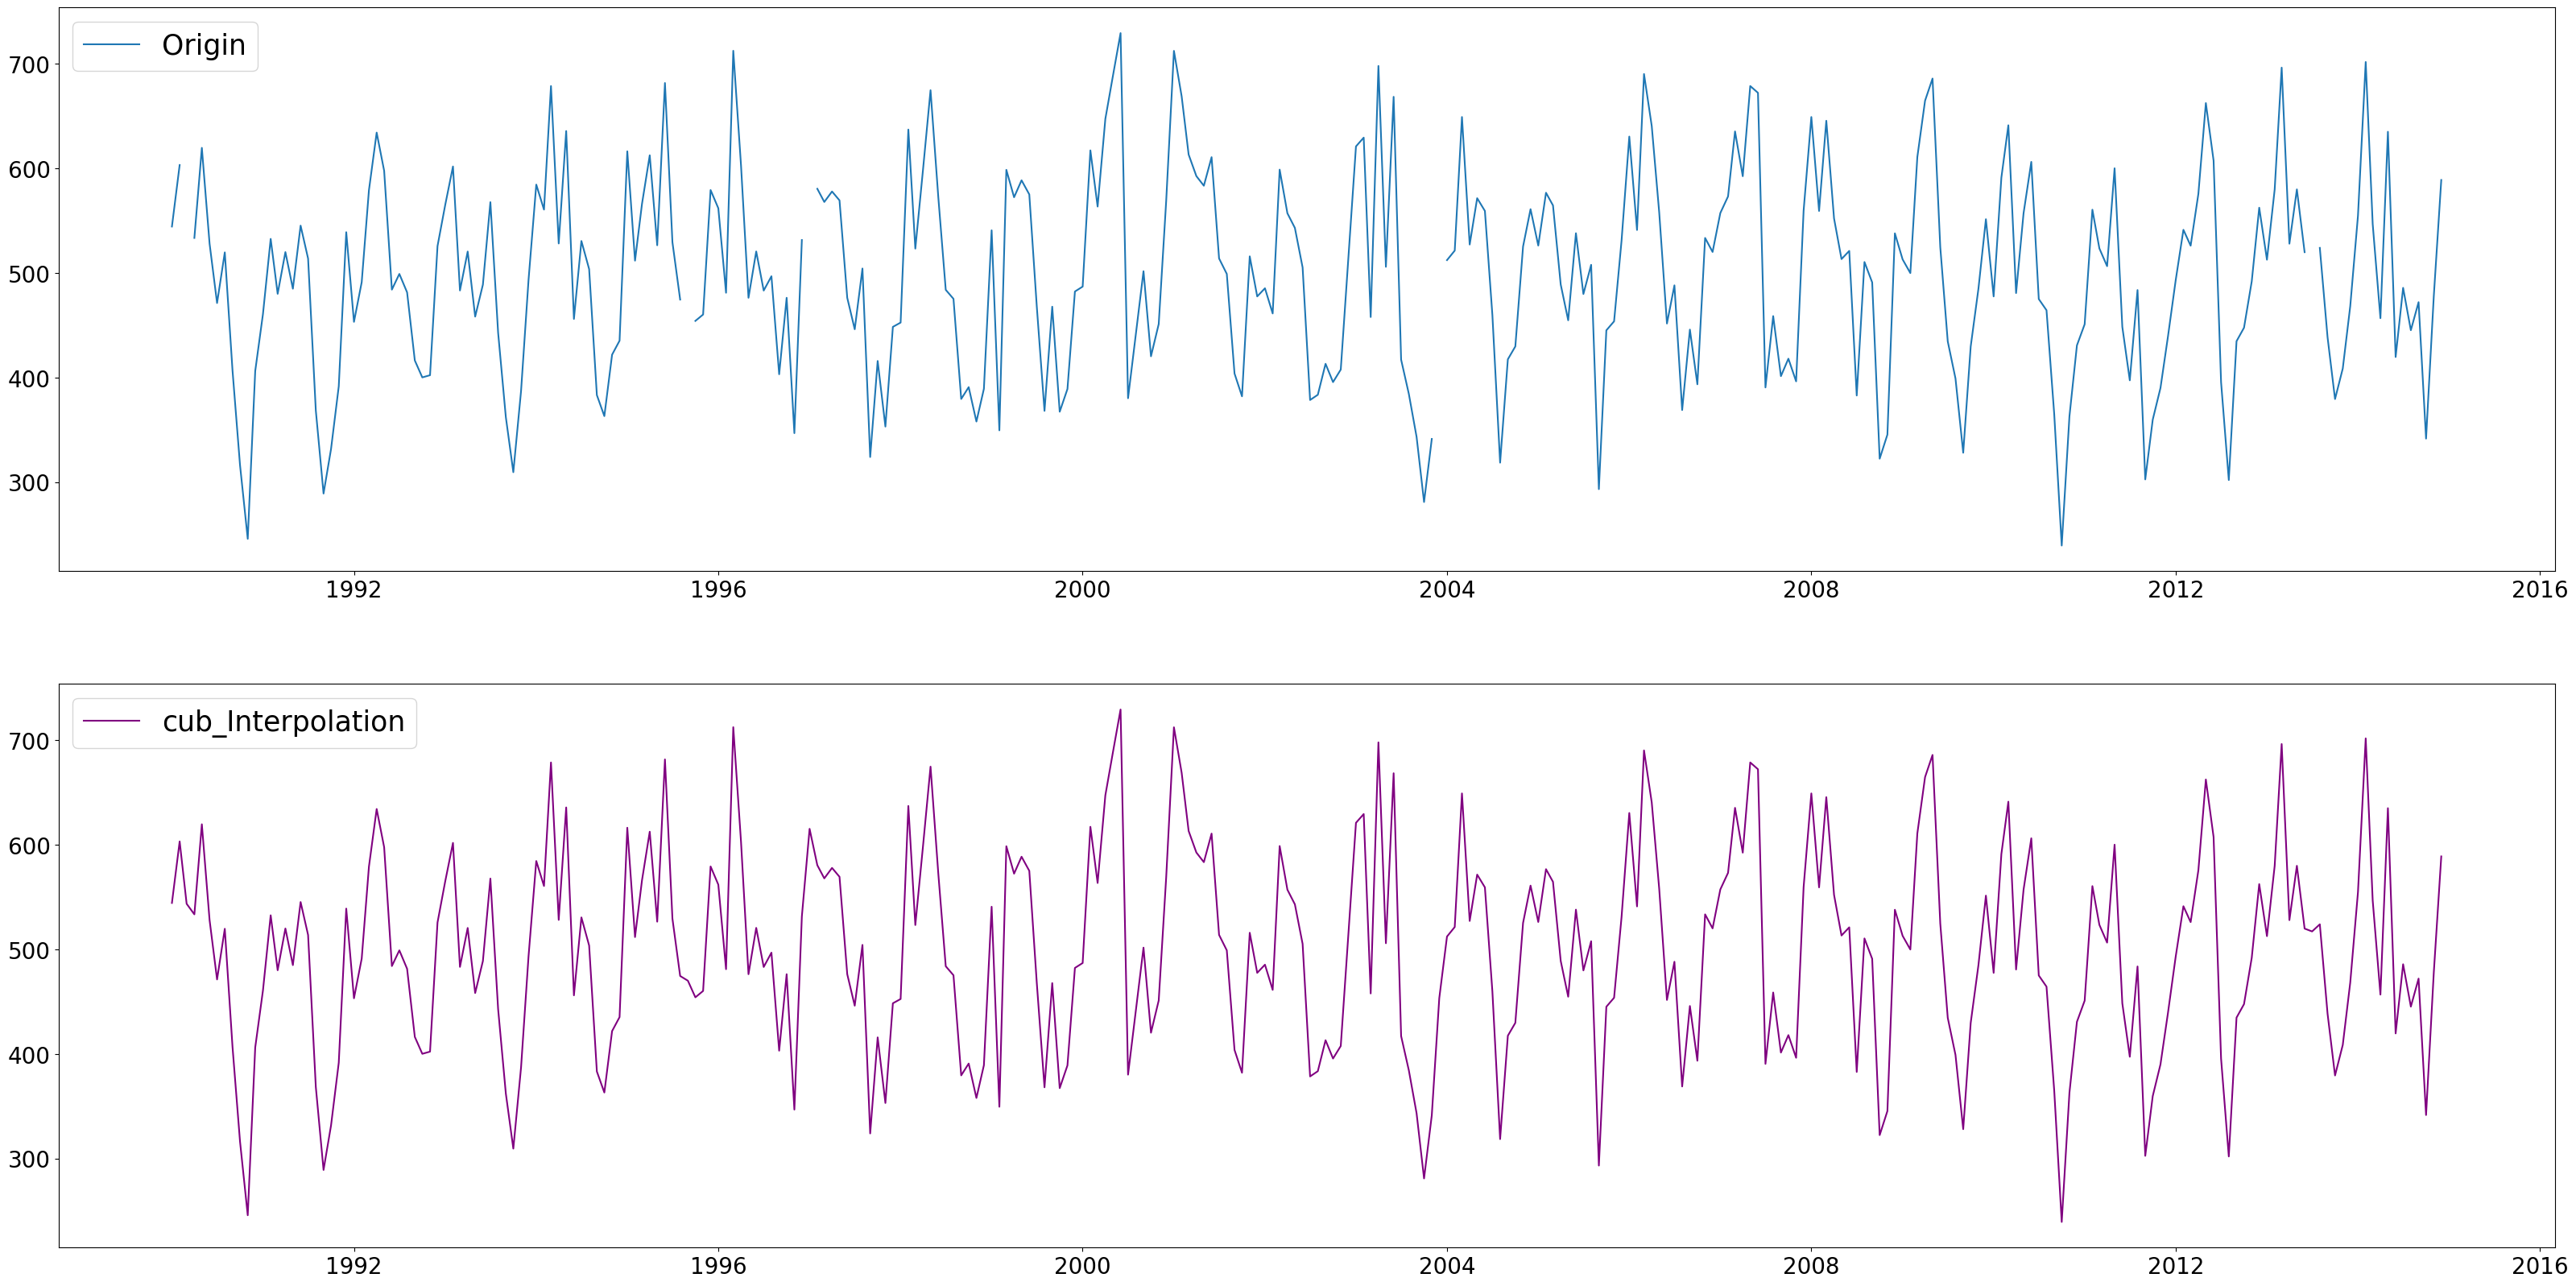

In [57]:
plt.figure(figsize=(40,20))

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.subplot(211)
plt.plot(df['date'], df['counts'], label='Origin')
plt.legend(fontsize=25)

plt.subplot(212)
plt.plot(df['date'], df['impute_cub_interpol'], color='purple', label='cub_Interpolation')
plt.legend(fontsize=25)

plt.show()

- 결측치를 처리하기 전 원래 그래프와, cubic 보간법으로 결측치를 처리한 그래프를 그려 비교
- 결측치 처리하기 전 그래프에서는 결측치로 인해 선이 끊겨있는 경우가 발생
- 결측치 처리한 그래프에서는 선이 부드럽게 이어진 결과를 확인 가능

In [58]:
# date 인덱스 지정
df_cub_interpol = df[['date', 'impute_cub_interpol']].set_index('date', drop=True)
df_cub_interpol

,impute_cub_interpol
date,
1990-01-01,544.300000
1990-02-01,603.100000
1990-03-01,543.513195
1990-04-01,533.400000
1990-05-01,619.500000
...,...
2014-08-01,445.200000
2014-09-01,472.000000
2014-10-01,341.600000


## 2-3) 계절성을 반영한 시계열 모델을 제시하고 정확도 측면에서 모델 성능 평가 할 것

- 시계열 분해 기법을 이용하여 시계열 데이터 확인

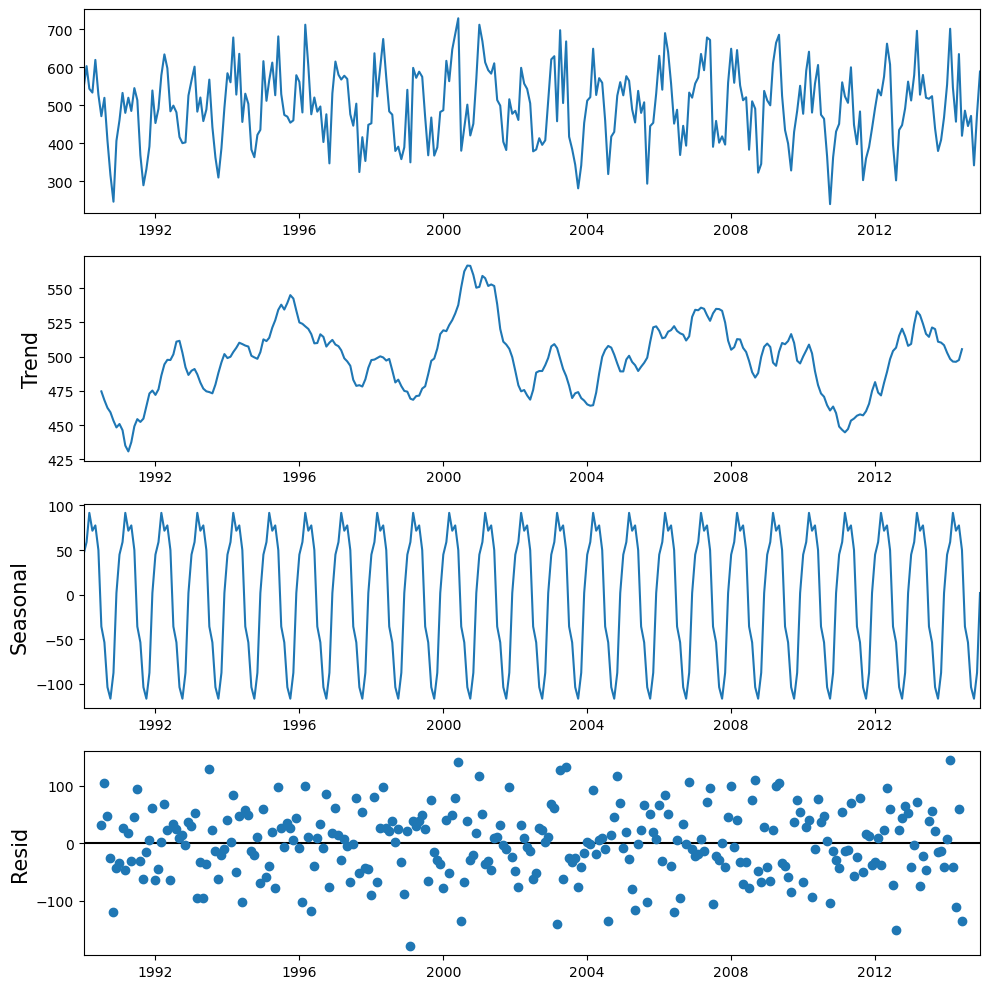

In [59]:
decomposition = sm.tsa.seasonal_decompose(df_cub_interpol, model='additive')

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=15)

fig = decomposition.plot()
fig.set_size_inches(10,10)

plt.tight_layout()
plt.show()

### 모델 평가를 위한 train, test 셋 분리

In [60]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_cub_interpol,
                                         test_size=0.2,
                                         shuffle=False)

print(train_data.shape, test_data.shape)

(240, 1) (60, 1)


### 정상성 검정

```
1) 현재 데이터는 정상성을 만족하지 않기 때문에, 차분을 통해 정상성 데이터로 변형한 후에 AR(p) 또는 MA(q) 모델을 사용할 수 있다. 
    => 차분을 하라고 할 수도 있으니 코드는 남기자
2) 만약 데이터가 정상성을 만족한다면, AR(p)모델 또는 MA(q)모델을 적용할 수 있다.
3) 만약 2)에서 차분과정이 하기 싫다면 ARMA에 차분이 들어간 ARIMA 모델을 사용하면 훨씬 간단하다.

- 시계열 정상성 확인 요약
* 평균 일정 X -> 차분
* 분산 일정 X -> 차분 이전에 로그 변환 수행 np.log로 변환가능

1. 시계열 데이터 불러와서 데이터 가공
2. 정규성, 이분산성 시각화 필요한지 확인 후 필요하면 수행
3. ACF, PACF 시각화 adf test로 비정상 시계열 확인
4. 차분 등 수행 후, 3번 과정과 비교하여 정상 시계열 변환 완료 확인

```

### 정상성 진단 방법 1) ADF 검정
- 시계열 데이터의 정상성을 진단하기 위해 ADF 검정을 실시한다.
- 귀무가설(H0) :  단위근이 존재한다 (비정상 시계열)
- 대립가설(H1) : 단위근이 없다 (정상 시계열)

In [61]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(train_data, autolag='AIC')

print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic: -2.805855891131175
p-value : 0.05744215212485013


#### ADF 검정 결과, 유의수준 5%에서 p-value가 0.05보다 크므로 귀무가설을 기각할 수 없다. 
#### 즉 정상성을 만족하지 않는다.

### 정상성 진단 방법 2) KPSS 검정
- 귀무가설(H0) : 시계열 과정이 정상적(Stationary)이다
- 대립가설(H1) : 시계열 과정이 비정상적(non-stationary)이다

In [75]:
from statsmodels.tsa.stattools import kpss
kpss_result = kpss(train_data)

print('kpss Statistic: {}'.format(kpss_result[0]))
print('p-value : {}'.format(kpss_result[1]))

kpss Statistic: 0.07462055976917832
p-value : 0.1


#### kpss로도 검정해봤는데, 정상성 만족
#### 유의수준 5%에서 p-value가 0.05보다 크므로 귀무가설을 기각할 수 없다. 따라서 정상시계열이라고 할 수 있다.

### 정상성 진단 방법 3) ACF Plot
- ACF 그래프 시각화 결과, acf plot이 천천히 감소하는 경향이 아니므로 정상 데이터라고 볼 수 있다.

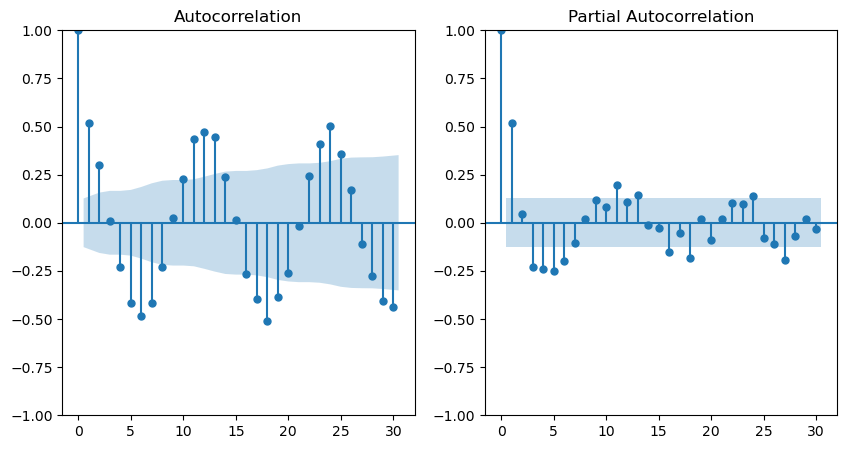

In [76]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])

plt.show()

#### 정상 데이터임을 확인
- adf 검정법에서 비정상 데이터라고 검정이 됐으나, acf 그래프와 kpss 등 여러 진단법을 고려해봤을 때 데이터는 정상 시계열 데이터라고 볼 수 있다고 판단했다. 따라서 계절성을 고려한 시계열 모형인 SARIMA를 구현한다.

### 참고 : 차분
본 데이터는 정상 시계열이지만, 비정상 시계열나오면 혹시 모르니 차분도 알아두자.

In [77]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data[['impute_cub_interpol']].diff()
diff_train_data = diff_train_data.dropna()

print('====== Raw Data ======')
display(train_data)

print('====== Differenced Data ======')
display(diff_train_data)

====== Raw Data ======


,impute_cub_interpol
date,
1990-01-01,544.300000
1990-02-01,603.100000
1990-03-01,543.513195
1990-04-01,533.400000
1990-05-01,619.500000
...,...
2009-08-01,399.100000
2009-09-01,328.100000
2009-10-01,429.600000


====== Differenced Data ======


,impute_cub_interpol
date,
1990-02-01,58.800000
1990-03-01,-59.586805
1990-04-01,-10.113195
1990-05-01,86.100000
1990-06-01,-91.600000
...,...
2009-08-01,-35.400000
2009-09-01,-71.000000
2009-10-01,101.500000


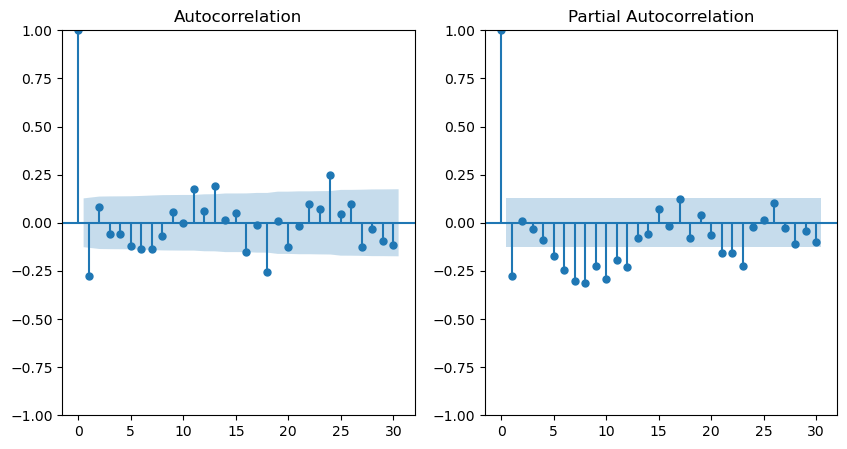

In [78]:
# 차분 후 acf, pacf

fig, ax = plt.subplots(1,2, figsize=(10,5))

sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])

plt.show()

### 시계열 모형

```
1. AR 모델 (AutoRegressive Model)
    1) 자기상관성을 시계열 모형으로 구성한 것으로, 변수의 과거 관측값의 선형 결합을 통해 변수의 미래값을 예측하는 모델이다.
    2) 이전의 관측값이 이후의 관측값에 영향을 준다는 아이디어에 기반하고 있다.
    3) 파라미터 값으로는 p를 이용하며 AR(p)의 형태로 나타낸다.


2. MA 모델 (Moving Average Model)
    1) 예측 오차를 이용하여 미래값을 예측하는 모델이다.
    2) 파라미터 값으로는 q를 이용하며 MA(q)의 형태로 나타낸다.
    
    
3. ARMA 모델 (안정시계열 모델)
    1) p개의 자기 자신의 과거값과 q개의 과거백색 잡음의 선형조합을 의미하고, AR(p) 모형과 MA(q)모형이 합쳐진 모델이다.
    2) AR(p)모형의 정상성, MA(q)모형의 가역성 조건을 만족해야 한다.
    3) 파라미터 값으로는 p,q를 이용하며, ARMA(p,q)의 형태로 나타낸다.
    4) ARMA는 값을 0을 주게 되면 AR, MA 모델과 동일해진다.
        (1) ARMA(1, 0) = AR(1)
        (2) ARMA(0, 1) = MA(1)
        (3) ARMA(1,1)은 가장 흔한 형태의 정상시계열 모델이다.
            - 성능 벤치마크로써 베이스 모델의 역할도 수행할 수 있다.


4. ARIMA 모델 (불안정 시계열 모델)
    1) ARMA 모델에서 d차 차분을 추가적으로 적용시킨 모델로 비정상시계열에도 바로 적용할 수 있다는 장점이 있다.
    2) ARIMA(p,d,q) : d차 차분한 데이터에 AR(p)모형과 MA(q)모형을 합친 모델
    3) I는 Integrated를 뜻하고 이는 '누적'을 의미
    4) ARIMA 모델 -> AR, MA
        (1) ARIMA(p,0,0) or ARIMA(p,1,0) = AR(p)
        (2) ARIMA(0,0,q) or ARIMA(0,1,q) = MA(q)
    5) p,d,q 값은 AIC, BIC, ACF, PACF등 다양한 방법을 통해서 선택할 수 있다.
    6) 자기상관(p,q)은 ACF, PACF 그래프를 그려서 확인합니다.
```

### ACF(Auto Correlation Function), PACF(Partial Auto Correlation Function)

|Model|ACF|PACF|
|-|---------------|------------------------|
|AR(p)|지수적으로 감소, 소멸하는 sin함수 형태|p+1차항 부터 0으로 절단|
|MA(q)|q+1차항 부터 0으로 절단|지수적으로 감소 소멸하는 sin함수 형태|
|ARMA(p,q)|q+1차항 부터 지수적 감소 혹은 진동하는 sin함수 형태|p+1차항 부터 지수적 감소 혹은 진동하는 sin함수 형태|

```
1. ACF(AutoCorrelation Function)
    1) 시차(lag)에 따른 연속적인 관측값 사이의 상호 연관관계를 의미하며, 시차가 커질 수록 0에 수렴한다.
    2) 동일한 변수를, 시점을 달리하여 관측했을 때 시점에 따라 다른값 사이의 상호 연관관계를 척도로 나타낸 것이다.
    3) ACF를 통해서 시계열 자료의 정상성을 파악할 수 있다.
    4) 정상시계열인 경우엔 상대적으로 빠르게 0에 수렴하고, 비정상시계열은 천천히 감소한다.
    5) MA, ARMA, ARIMA에서 q값을 구하는 경우에 ACF 그래프를 통해서 구할 수 있으며, 처음 0으로 수렴하게되는 시점을 q값으로 잡으면 된다.
        (1) 정확하게는 0을 중심으로하는 신뢰구간(95%에선 0 ± 1.96/sqrt(n))에 진입하는 최초의 시점을 q값으로 설정.
        (2) 시계열 데이터가 MA의 특성을 띄는 경우 ACF는 급격하게 감소합니다.


2. PACF(Partial ACF, 부분자기상관함수)
    1) 시차(lag)에 따른 편자기상관을 의미하며, 시차가 다른 두 시계열간의 순수한 상호연관관계를 의미한다.
    2) AR, ARMA, ARIMA에서 p값을 구하는 경우에 PACF 그래프를 통해서 구할 수 있으며, 0으로 수혐하게 되는 시점을 p값으로 잡으면 된다.
        (1) 정확하게는 0을 중심으로하는 신뢰구간(95%에선 0 ± 1.96/sqrt(n)) 에 진입하는 최초의 시점을 p값으로 설정한다.
        (2) 시계열 데이터가 AR의 특성을 띄는 경우 PACF는 급격하게 감소한다.
```

<br/>

```
- 결과: 정상성을 만족하는 시계열 데이터이고, ACF/PACF를 통해 ARMA(p,q)가 적절해 보인다.
```

### 정상성에 따른 모델링
```
1. train data가 정상성을 만족하지 않을 떄
    1) 현재 train data가 정상성을 만족하지 않으므로, 차분을 한 후 ACF, PACF 그래프를 그렸다.
    2) 차분을 한 후 그린 ACF, PACF에서 어떠한 시계열 모델을 적용할 지 생각한다.
    3) 그 다음 역시 ACF, PACF 그래프에서 대략적으로 q, p를 추측할 수 있다.
    4) 그 다음 모델을 만들때, d 파라미터 자리에 차분값을 넣어주면 된다.


2. train data가 정상성을 만족할 때
    1) 현재 train data가 정상성을 만족하므로, 바로 ACF, PACF 그래프를 그렸다.
    2) 그린 ACF, PACF에서 어떠한 시계열 모델을 적용할 지 생각한다.
    3) 그 다음 역시 ACF, PACF 그래프에서 대략적으로 q, p를 추측할 수 있다.
    4) 그 다음 모델을 만들때, d 파라미터 자리에 차분값을 넣어주지 않아도 된다.
```

```python
# model.fit() 옵션
trend='c'는 모형에 상수(intercept)를 포함하도록 설정하는 매개변수
disp=False는 피팅 과정에서의 출력을 숨기는 옵션
```

### 1) AR 모형 : AR(p)의 형태

In [79]:
orders = (2, 1, 0)  # q=0 이어야 AR (ARIMA(p,d,q))

AR = sm.tsa.ARIMA(train_data, order=orders)

AR_fit = AR.fit()
AR_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     impute_cub_interpol   No. Observations:                  240
Model:                  ARIMA(2, 1, 0)   Log Likelihood               -1419.247
Date:                 Fri, 02 Jun 2023   AIC                           2844.495
Time:                         11:53:31   BIC                           2854.924
Sample:                     01-01-1990   HQIC                          2848.698
                          - 12-01-2009                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2750      0.073     -3.758      0.000      -0.418      -0.132
ar.L2          0.0071      0.073      0.097      0.923      -0.137       0.151
sigma2      8468.6247    762.546     11.106      0.000    6974.062    9963.187
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.36
Prob(Q):                              0.99   Prob(JB):                         0.31
Heteroskedasticity (H):               1.22   Skew:                            -0.22
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 2) MA 모형

In [80]:
orders = (0, 1, 2)  # p=0이어야 MA

MA = sm.tsa.ARIMA(train_data, order=orders)

MA_fit = MA.fit()
MA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     impute_cub_interpol   No. Observations:                  240
Model:                  ARIMA(0, 1, 2)   Log Likelihood               -1419.530
Date:                 Fri, 02 Jun 2023   AIC                           2845.061
Time:                         11:53:33   BIC                           2855.490
Sample:                     01-01-1990   HQIC                          2849.263
                          - 12-01-2009                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2693      0.073     -3.709      0.000      -0.412      -0.127
ma.L2          0.0533      0.068      0.780      0.435      -0.080       0.187
sigma2      8439.1697    763.367     11.055      0.000    6942.998    9935.341
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.21
Prob(Q):                              0.92   Prob(JB):                         0.33
Heteroskedasticity (H):               1.23   Skew:                            -0.22
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3) ARMA 모형 
- 비정상 데이터라면 **차분**으로 정상성을 맞춘 후에 ARMA 적용
- 애초에 정상성 띄면 차분할 필요 없음

In [81]:
orders = (2, 1, 2) # 차분된 데이터가 들어가야함

ARMA = sm.tsa.ARIMA(train_data, order=orders)

ARMA_fit = ARMA.fit()
ARMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     impute_cub_interpol   No. Observations:                  240
Model:                  ARIMA(2, 1, 2)   Log Likelihood               -1397.767
Date:                 Fri, 02 Jun 2023   AIC                           2805.534
Time:                         11:53:33   BIC                           2822.916
Sample:                     01-01-1990   HQIC                          2812.539
                          - 12-01-2009                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4458      0.102     -4.349      0.000      -0.647      -0.245
ar.L2          0.4968      0.075      6.601      0.000       0.349       0.644
ma.L1         -0.0233      6.178     -0.004      0.997     -12.132      12.086
ma.L2         -0.9766      6.058     -0.161      0.872     -12.849      10.896
sigma2      6909.5833   4.27e+04      0.162      0.871   -7.68e+04    9.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.59   Prob(JB):                         0.92
Heteroskedasticity (H):               1.22   Skew:                            -0.05
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 4) ARIMA 모형
- ARMA에 차분(Integration)을 적용한 모델
    - 차분(Integration)을 통해 Non-Stationary를 Stationary로 바꿔준다.

In [82]:
orders = (2, 1, 3)

ARIMA = sm.tsa.ARIMA(train_data, order=orders)

ARIMA_fit = ARIMA.fit()
ARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     impute_cub_interpol   No. Observations:                  240
Model:                  ARIMA(2, 1, 3)   Log Likelihood               -1362.585
Date:                 Fri, 02 Jun 2023   AIC                           2737.169
Time:                         11:53:34   BIC                           2758.028
Sample:                     01-01-1990   HQIC                          2745.575
                          - 12-01-2009                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7194      0.007    232.344      0.000       1.705       1.734
ar.L2         -0.9906      0.006   -159.592      0.000      -1.003      -0.978
ma.L1         -2.6831      0.114    -23.633      0.000      -2.906      -2.461
ma.L2          2.6631      0.192     13.862      0.000       2.287       3.040
ma.L3         -0.9797      0.111     -8.790      0.000      -1.198      -0.761
sigma2      6221.0135    887.038      7.013      0.000    4482.452    7959.575
===================================================================================
Ljung-Box (L1) (Q):                   6.45   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.01   Prob(JB):                         0.98
Heteroskedasticity (H):               0.98   Skew:                             0.03
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 정상성에 따른 모델링 방법 2
```
- 아래처럼 최적의 p, d, q 조합을 AIC를 통해 찾는 함수를 선언하고 최적의 파라미터를 찾는다.
```

In [83]:
def arima_aic_check(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = sm.tsa.ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p:{p} d:{d} q:{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [84]:
arima_aic_check(train_data, [3,3,3])

,order,AIC
20,p:2 d:0 q:2,2717.206859
14,p:1 d:1 q:2,2803.827484
11,p:1 d:0 q:2,2804.891620
23,p:2 d:1 q:2,2805.534062
2,p:0 d:0 q:2,2808.432406
9,p:1 d:0 q:0,2808.836370
19,p:2 d:0 q:1,2810.118881
18,p:2 d:0 q:0,2810.300171
10,p:1 d:0 q:1,2810.556676
1,p:0 d:0 q:1,2831.156695


In [85]:
orders = (2, 0, 2)

ARIMA_opt_model = sm.tsa.ARIMA(train_data, order=orders)

ARIMA_opt_model_fit = ARIMA_opt_model.fit()
ARIMA_opt_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     impute_cub_interpol   No. Observations:                  240
Model:                  ARIMA(2, 0, 2)   Log Likelihood               -1352.603
Date:                 Fri, 02 Jun 2023   AIC                           2717.207
Time:                         11:53:40   BIC                           2738.091
Sample:                     01-01-1990   HQIC                          2725.622
                          - 12-01-2009                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        501.2276      4.347    115.300      0.000     492.707     509.748
ar.L1          1.7301      0.001   1223.684      0.000       1.727       1.733
ar.L2         -1.0000   9.26e-05  -1.08e+04      0.000      -1.000      -1.000
ma.L1         -1.7283      0.083    -20.801      0.000      -1.891      -1.565
ma.L2          1.0000      0.094     10.643      0.000       0.816       1.184
sigma2      4418.6701   3.89e-05   1.14e+08      0.000    4418.670    4418.670
===================================================================================
Ljung-Box (L1) (Q):                   3.67   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.06   Prob(JB):                         0.93
Heteroskedasticity (H):               1.01   Skew:                             0.04
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.06e+25. Standard errors may be unstable.
"""

In [94]:
from sklearn.metrics import r2_score

# 최적의 모델을 사용한 예측

# 예측 객체
ARIMA_opt_pred = ARIMA_opt_model_fit.get_prediction(start=pd.to_datetime('2010-01-01'),
                                                    end=pd.to_datetime('2014-12-01') ,
                                                    dynamic=True)
# (또 다른 방법) time_series_ARIMA_opt_model_fit.forecast( len( test_data)).values  
# test_data 갯수만큼 예측해줌


# 예측 값
ARIMA_opt_pred_val = ARIMA_opt_pred.predicted_mean.values
    
# 신뢰구간
ARIMA_opt_pred_ci = ARIMA_opt_pred.conf_int()

# 그래프 그릴 때 x축(인덱스)
ARIMA_opt_pred_index = list(test_data.index)

# 결정계수
r2_ARIMA = round(r2_score(test_data, ARIMA_opt_pred_val),2)

print("ARIMA 결정계수 : ", r2_ARIMA)

ARIMA 결정계수 :  0.47


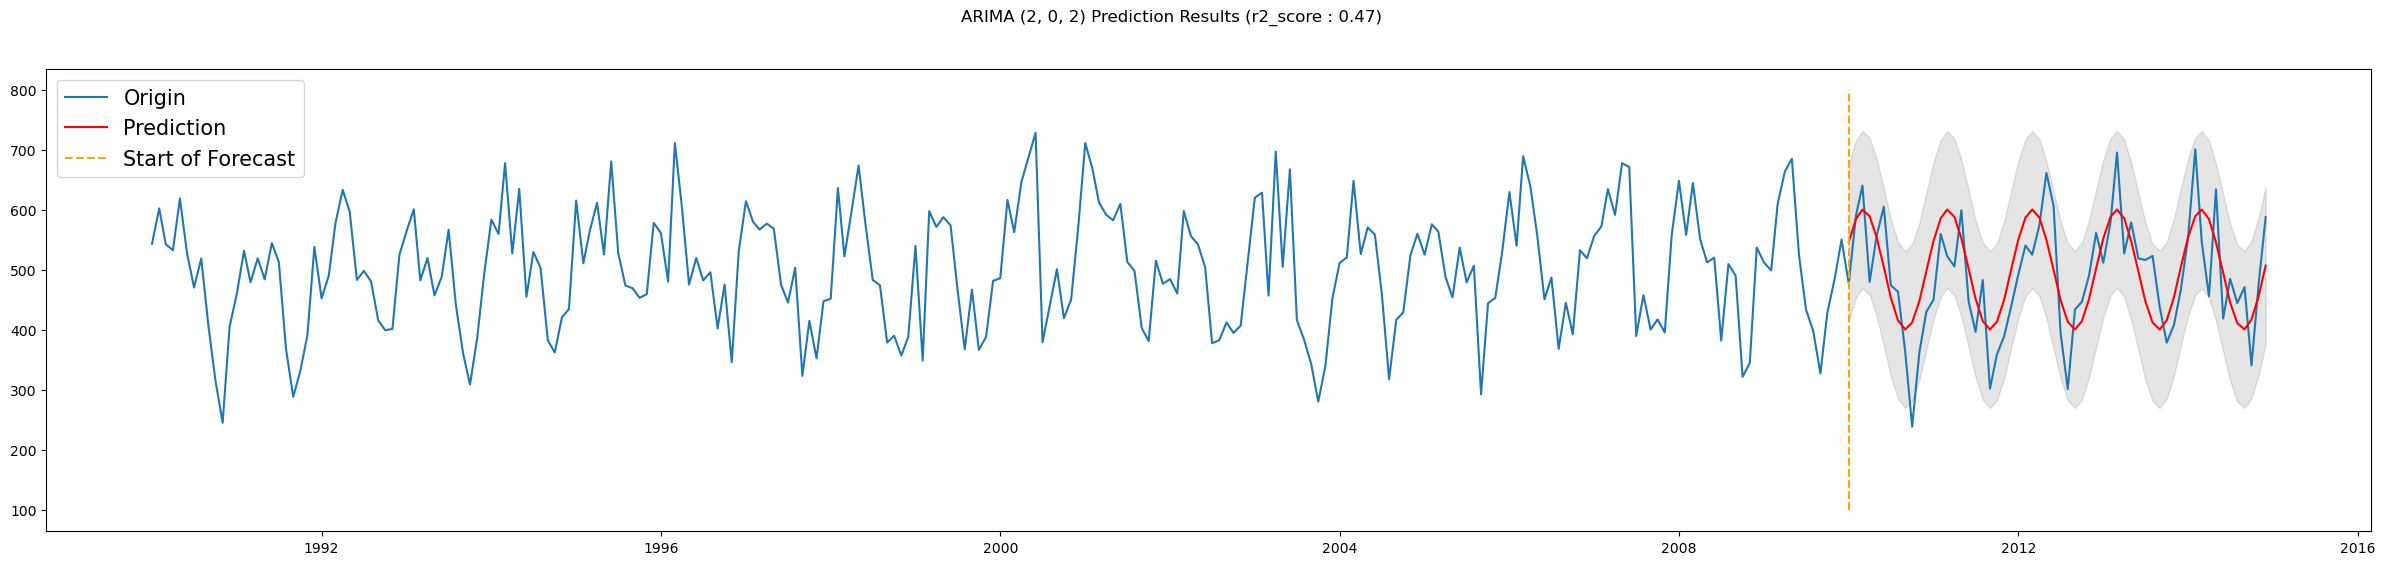

In [95]:
plt.figure(figsize=(30,6))

plt.plot(df_cub_interpol['impute_cub_interpol'], label='Origin')
plt.plot(ARIMA_opt_pred_index, ARIMA_opt_pred_val, color='red', label='Prediction')

plt.fill_between(ARIMA_opt_pred_ci.index,
                ARIMA_opt_pred_ci.iloc[:, 0],
                ARIMA_opt_pred_ci.iloc[:, 1], color='k', alpha=.1)

plt.vlines(ARIMA_opt_pred_index[0], 100, 800, 
           linestyle='--', color='orange', label='Start of Forecast')  # 예측 시작점

plt.suptitle('ARIMA {0} Prediction Results (r2_score : {1})'.format(orders, r2_ARIMA))
plt.legend(loc='upper left', fontsize=15)
plt.show()

### 5) SARIMA 모형

In [96]:
import itertools

p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
#계절성이 12일 마다 있다고 가정
seasonal_pdq

[(0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12)]

In [97]:
aic = []
params=[]
for i in pdq:
    for j in seasonal_pdq:
        try:
            model=SARIMAX(train_data.values, order=(i), seasonal_order=(j))
            model_fit = model.fit()
            print(f'SARIMA : {i}{j} >> AIC: {round(model_fit.aic, 2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i,j))

        except:
            continue

SARIMA : (0, 1, 0)(0, 1, 0, 12) >> AIC: 2861.52
SARIMA : (0, 1, 0)(0, 1, 1, 12) >> AIC: 2706.88
SARIMA : (0, 1, 0)(0, 1, 2, 12) >> AIC: 2704.12
SARIMA : (0, 1, 0)(1, 1, 0, 12) >> AIC: 2761.25
SARIMA : (0, 1, 0)(1, 1, 1, 12) >> AIC: 2702.15
SARIMA : (0, 1, 0)(1, 1, 2, 12) >> AIC: 2703.69
SARIMA : (0, 1, 0)(2, 1, 0, 12) >> AIC: 2736.08
SARIMA : (0, 1, 0)(2, 1, 1, 12) >> AIC: 2703.83
SARIMA : (0, 1, 0)(2, 1, 2, 12) >> AIC: 2705.55
SARIMA : (0, 1, 1)(0, 1, 0, 12) >> AIC: 2727.87
SARIMA : (0, 1, 1)(0, 1, 1, 12) >> AIC: 2589.72
SARIMA : (0, 1, 1)(0, 1, 2, 12) >> AIC: 2591.46
SARIMA : (0, 1, 1)(1, 1, 0, 12) >> AIC: 2649.17
SARIMA : (0, 1, 1)(1, 1, 1, 12) >> AIC: 2585.3
SARIMA : (0, 1, 1)(1, 1, 2, 12) >> AIC: 2595.6
SARIMA : (0, 1, 1)(2, 1, 0, 12) >> AIC: 2625.34
SARIMA : (0, 1, 1)(2, 1, 1, 12) >> AIC: 2587.28
SARIMA : (0, 1, 1)(2, 1, 2, 12) >> AIC: 2595.44
SARIMA : (0, 1, 2)(0, 1, 0, 12) >> AIC: 2728.88
SARIMA : (0, 1, 2)(0, 1, 1, 12) >> AIC: 2591.31
SARIMA : (0, 1, 2)(0, 1, 2, 12) >> AIC: 25

In [98]:
optimal = [(params[i], j) for i,j in enumerate(aic) if j==min(aic)]
optimal

[(((0, 1, 1), (1, 1, 1, 12)), 2585.3)]

In [99]:
## Define SARIMAX model and fit it to the data
orders = (0, 1, 1)
seasonal_orders = (1, 1, 1, 12)

SARIMA_opt_model = sm.tsa.statespace.SARIMAX(endog=train_data, 
                                             order=orders,
                                             seasonal_order=seasonal_orders,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
SARIMA_opt_model_fit = SARIMA_opt_model.fit()

# 결과
SARIMA_opt_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                impute_cub_interpol   No. Observations:                  240
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1288.648
Date:                            Fri, 02 Jun 2023   AIC                           2585.296
Time:                                    12:16:11   BIC                           2598.996
Sample:                                01-01-1990   HQIC                          2590.824
                                     - 12-01-2009                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8890      0.032    -27.828      0.000      -0.952      -0.826
ar.S.L12      -0.2000      0.076     -2.622      0.009      -0.350      -0.050
ma.S.L12      -0.8495      0.057    -14.952      0.000      -0.961      -0.738
sigma2      4543.7272    489.073      9.290      0.000    3585.161    5502.293
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                 1.98
Prob(Q):                              0.48   Prob(JB):                         0.37
Heteroskedasticity (H):               1.12   Skew:                            -0.01
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMA를 통한 예측

In [100]:
from sklearn.metrics import r2_score

# 예측 객체
# (또 다른 방법) time_series_SARIMA_opt_model_fit.forecast( len( test_data)).values  
# test_data 갯수만큼 예측
SARIMA_opt_pred = SARIMA_opt_model_fit.get_prediction(start=pd.to_datetime('2010-01-01'),
                                                      end=pd.to_datetime('2014-12-01'),
                                                      dynamic=True)

# 예측 값
SARIMA_opt_pred_val = SARIMA_opt_pred.predicted_mean.values
    
# 신뢰구간
SARIMA_opt_pred_ci = SARIMA_opt_pred.conf_int()

# 그래프 그릴 때 x축(인덱스)
SARIMA_opt_pred_index = list(test_data.index)

# 결정계수
r2_SARIMA = round(r2_score(test_data, SARIMA_opt_pred_val),2)
print("SARIMA 결정계수 : ", r2_SARIMA)

SARIMA 결정계수 :  0.44


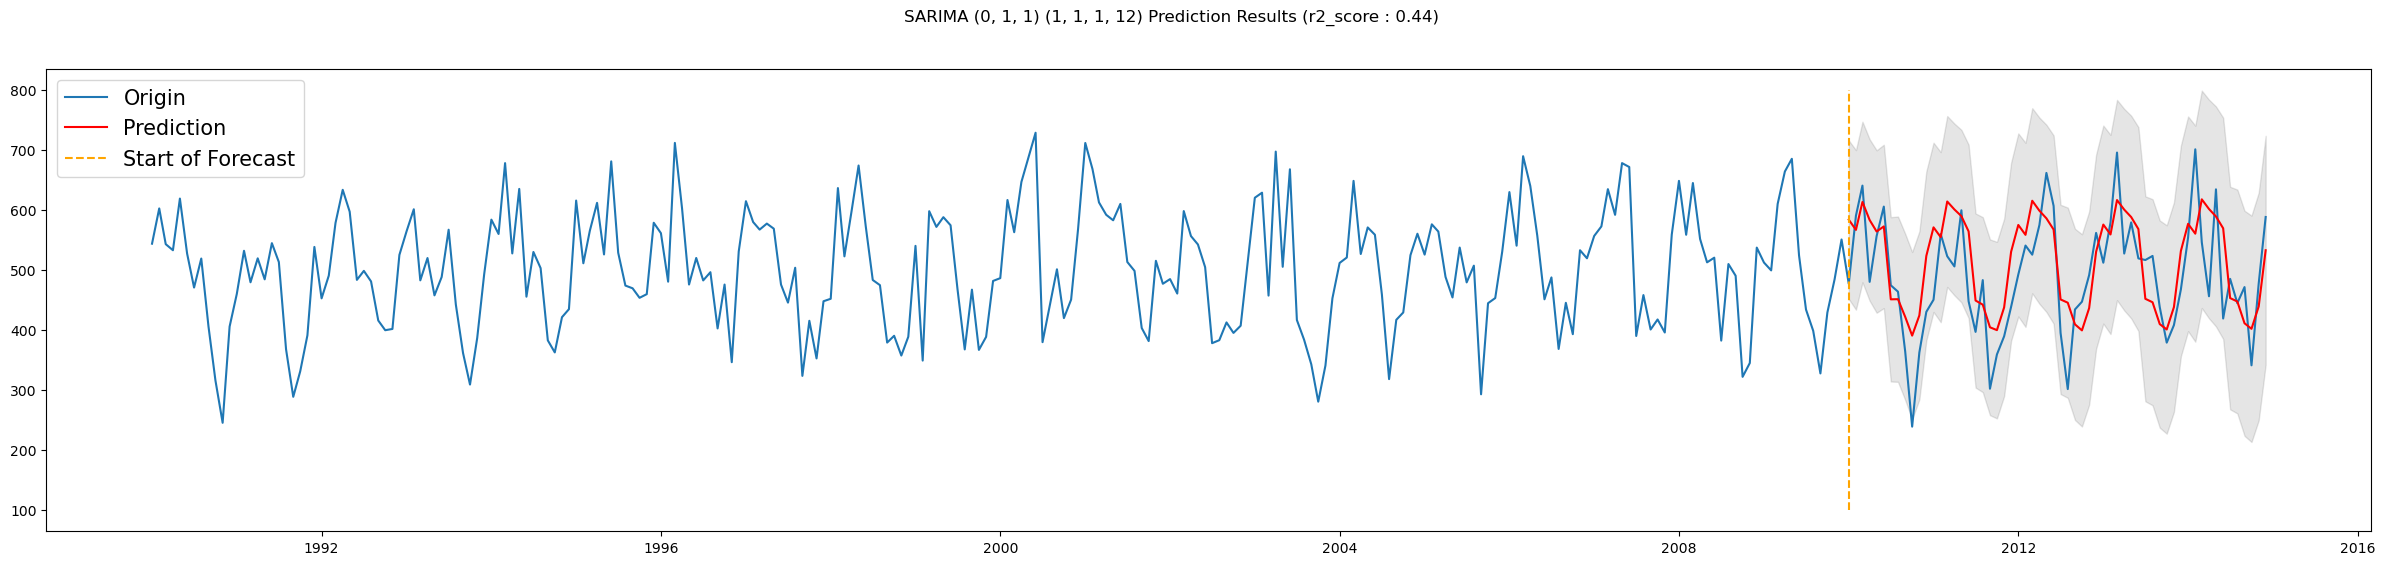

In [101]:
plt.figure(figsize=(30,6))

plt.plot(df_cub_interpol['impute_cub_interpol'], label='Origin')

plt.plot(SARIMA_opt_pred_index, SARIMA_opt_pred_val, color='red', label='Prediction')

plt.fill_between(SARIMA_opt_pred_ci.index,
                SARIMA_opt_pred_ci.iloc[:, 0],
                SARIMA_opt_pred_ci.iloc[:, 1], color='k', alpha=.1)

plt.vlines(SARIMA_opt_pred_index[0], 100, 800, 
           linestyle='--', color='orange', label='Start of Forecast')  # 예측 시작점

plt.suptitle('SARIMA {0} {1} Prediction Results (r2_score : {2})'.format(orders, 
                                                                         seasonal_orders, 
                                                                         r2_SARIMA))
plt.legend(loc='upper left', fontsize=15)
plt.show()

### 시계열 모델의 평가는 회귀 모델의 평가지표와 동일 !
```python
from sklearn import metrics

def mae(y_true, y_pred):
    return metrics.mean_absolute_error(y_true,y_pred) #MAE
def mse(y_true, y_pred):
    return metrics.mean_squared_error(y_true,y_pred) # MSE
def rmse(y_true, y_pred):    
    return np.sqrt(metrics.mean_squared_error(y_true,y_pred))  # RMSE
def r2(y_true, y_pred):    
    return metrics.r2_score(y_true,y_pred) # R2
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100 # MAPE

def get_score(model, y_true, y_pred):
    model = model
    mae_val = mae(y_true, y_pred)
    mse_val = mse(y_true, y_pred)
    rmse_val = rmse(y_true, y_pred)
    r2_val = r2(y_true, y_pred)
    mape_val = mape(y_true, y_pred)
    
    score_dict = {"model": model,
                  "mae" :  mae_val,
                  "mse" :  mse_val,
                  "rmse" : rmse_val,
                  "r2":    r2_val, 
                  "mape" : mape_val
                 }
    return score_dict
```

### RMSE
- 예측 모델의 정확성을 평가하는 데 자주 사용되는 지표 중 하나
- **값이 작을수록 예측 모델의 정확성이 높다고 판단**

In [102]:
def rmse_(real, pred):
    difference = real-pred
    difference_2=np.sqrt(difference**2)
    return difference_2.mean()

- reshape(1,-1)을 사용하여 배열을 1행 n열의 형태로 변환
- flatten()을 사용하여 1차원 배열로 평탄화
- 테스트 데이터의 실제 값들이 1차원 배열로 준비

In [103]:
# SARIMA
rmse_(test_data.values.reshape(1,-1).flatten(), SARIMA_opt_pred_val)

60.150487236320714

### 제일 쉽게 ARIMA 모델링 하기 => Auto ARIMA

```python
# 직접 지정해주어 모델링 실시
model = pm.auto_arima(y=train,		# 데이터
                      d=n_diffs,	# 차분 (d), 기본값 = None
                      start_p= 0,	# 시작 p값, 기본값 = 2
                      max_p = 5,	# p 최대값, 기본값 = 5
                      start_q= 0,	# 시작 q값, 기본값 = 2
                      max_q = 5,	# q 최대값, 기본값 = 5
                      m=1,			# season의 주기, 기본값 = 1
                      seasonal=False,	# sARIMA를 실시, 기본값 = True
                      stepwise=True,	# stepwise algorithm, 기본값 = False
                      trace=True)		# 각 step을 출력할지, 기본값 = False

'''
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=967.793, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=969.462, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=969.432, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=969.948, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=971.366, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.266 seconds
'''
```

In [104]:
# 직접 지정해주어 모델링 실시

auto_arima_model = auto_arima(train_data,
                              #d = 1,          # 차분 (d), 기본값 = None
                              start_p = 0,    # 시작 p값, 기본값 = 2
                              max_p = 2,      # p 최대값, 기본값 = 5
                              start_q = 0,    # 시작 q값, 기본값 = 2
                              max_q = 2,      # q 최대값, 기본값 = 5
                              m = 12,         # season의 주기, 기본값 = 1
                              seasonal=False, # sARIMA를 실시, 기본값 = False
                              stepwise=False,  # stepwise algorithm, 기본값 = True
                              trace=True)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3675.908, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3419.584, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3260.671, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2874.951, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2859.794, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2861.278, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2860.701, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2862.607, Time=0.31 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.735 seconds


In [105]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1426.897
Date:                Fri, 02 Jun 2023   AIC                           2859.794
Time:                        12:16:18   BIC                           2870.236
Sample:                    01-01-1990   HQIC                          2864.002
                         - 12-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9918      0.009    113.999      0.000       0.975       1.009
ma.L1         -0.2692      0.075     -3.610      0.000      -0.415      -0.123
sigma2      8441.6971    788.841     10.701      0.000    6895.597    9987.797
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.87   Prob(JB):                         0.41
Heteroskedasticity (H):               1.24   Skew:                            -0.20
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
auto_arima_pred = auto_arima_model.predict(len(test_data), return_conf_int=True)
auto_arima_pred_val = auto_arima_pred[0]

auto_arima_ub = auto_arima_pred[1][:, 0]
auto_arima_lb = auto_arima_pred[1][:, 1]

auto_arima_index = list(test_data.index)
r2_auto_arima = r2_score(test_data, auto_arima_pred_val)

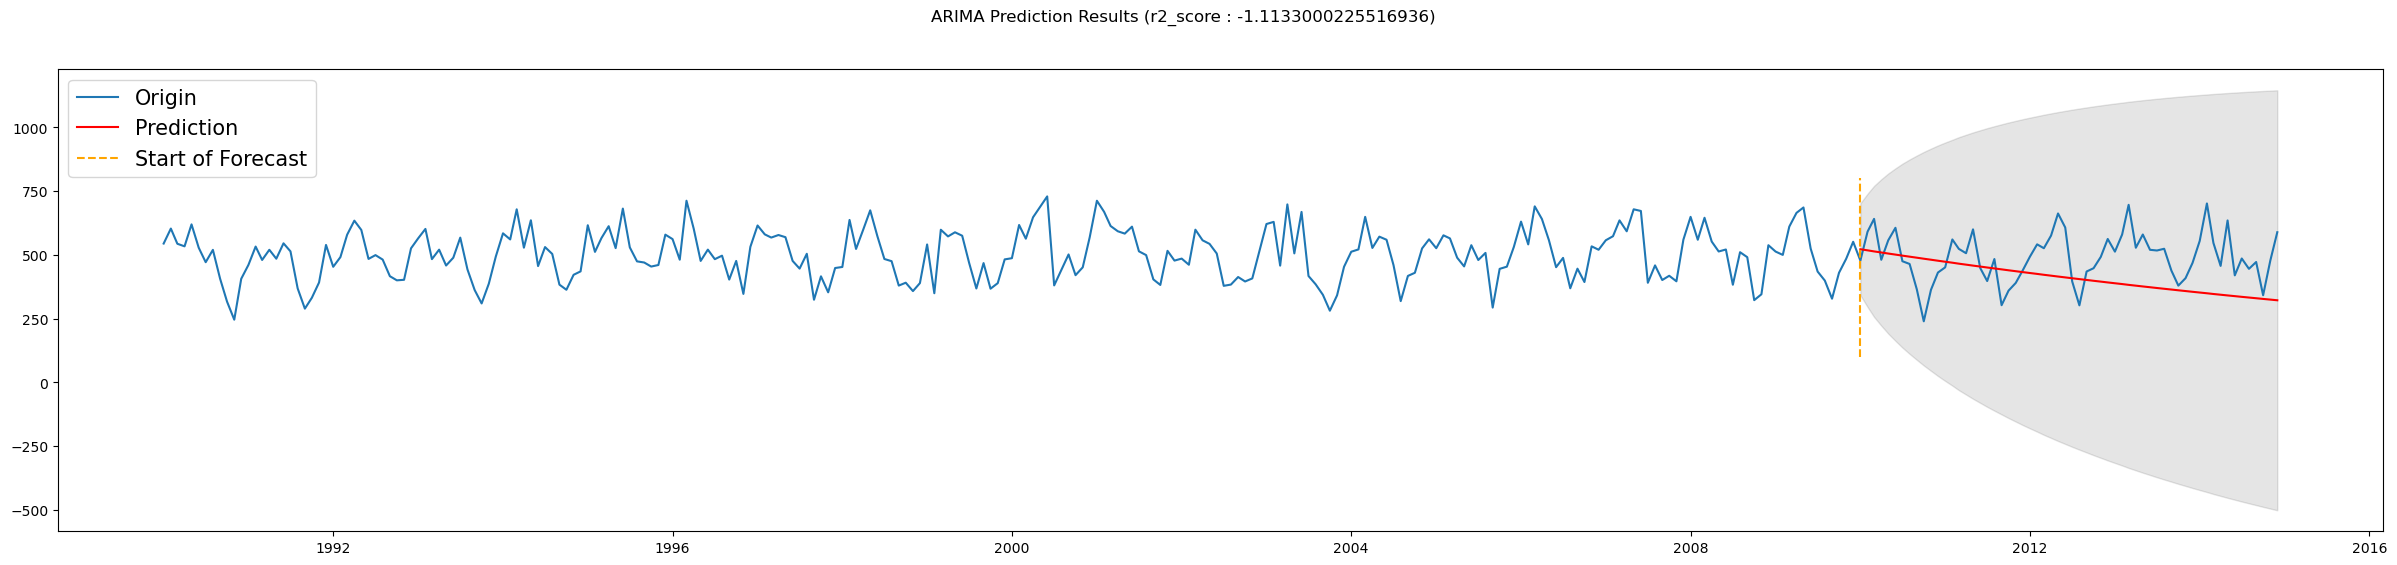

In [107]:
plt.figure(figsize=(30,6))

plt.plot(df_cub_interpol['impute_cub_interpol'], label='Origin')
plt.plot(auto_arima_index, auto_arima_pred_val, color='red', label='Prediction')

plt.fill_between(auto_arima_index,
                auto_arima_lb,
                auto_arima_ub, color='k', alpha=.1)

plt.vlines(auto_arima_index[0], 100, 800, 
           linestyle='--', color='orange', label='Start of Forecast')  # 예측 시작점


plt.suptitle('ARIMA Prediction Results (r2_score : {0})'.format(r2_auto_arima))
plt.legend(loc='upper left', fontsize=15)
#plt.show()

### auto SARIMA

In [108]:
# SARIMA

auto_sarima_model = auto_arima(train_data,
                              #d = 1,          # 차분 (d), 기본값 = None
                              start_P = 0,    # 시작 p값, 기본값 = 2
                              max_P = 2,      # p 최대값, 기본값 = 5
                              start_Q = 0,    # 시작 q값, 기본값 = 2
                              max_Q = 2,      # q 최대값, 기본값 = 5
                              m = 12,         # season의 주기, 기본값 = 1
                              seasonal=True, # sARIMA를 실시, 기본값 = False
                              stepwise=False,  # stepwise algorithm, 기본값 = True
                              trace=True)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2881.338, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=2846.857, Time=0.31 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=2820.571, Time=0.93 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=2816.832, Time=0.96 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=2771.624, Time=1.07 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=2822.519, Time=2.15 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2882.638, Time=4.61 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.57 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.23 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2831.157, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2819.084, Time=0.60 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=2797.184, Time=1.57 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2805.227, Time=0.85 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2794.755, Time=1.30 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=2799.002, Time=3.09 sec
 ARIM

In [111]:
auto_sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood               -1378.096
Date:                            Fri, 02 Jun 2023   AIC                           2770.193
Time:                                    12:21:54   BIC                           2794.557
Sample:                                01-01-1990   HQIC                          2780.010
                                     - 12-01-2009                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    248.2277     97.654      2.542      0.011      56.828     439.627
ar.L1         -0.9545      0.066    -14.403      0.000      -1.084      -0.825
ma.L1          0.9823      0.052     19.000      0.000       0.881       1.084
ar.S.L12       0.4509      0.165      2.734      0.006       0.128       0.774
ar.S.L24       0.2953      0.090      3.291      0.001       0.119       0.471
ma.S.L12      -0.2507      0.175     -1.435      0.151      -0.593       0.092
sigma2      5496.7563    573.600      9.583      0.000    4372.520    6620.992
===================================================================================
Ljung-Box (L1) (Q):                  13.68   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.00   Prob(JB):                         0.98
Heteroskedasticity (H):               1.07   Skew:                             0.02
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [112]:
auto_sarima_pred = auto_sarima_model.predict(len(test_data), return_conf_int=True)
auto_sarima_pred_val = auto_sarima_pred[0]

auto_sarima_ub = auto_sarima_pred[1][:, 0]
auto_sarima_lb = auto_sarima_pred[1][:, 1]

auto_sarima_index = list(test_data.index)
r2_auto_sarima = r2_score(test_data, auto_sarima_pred_val)

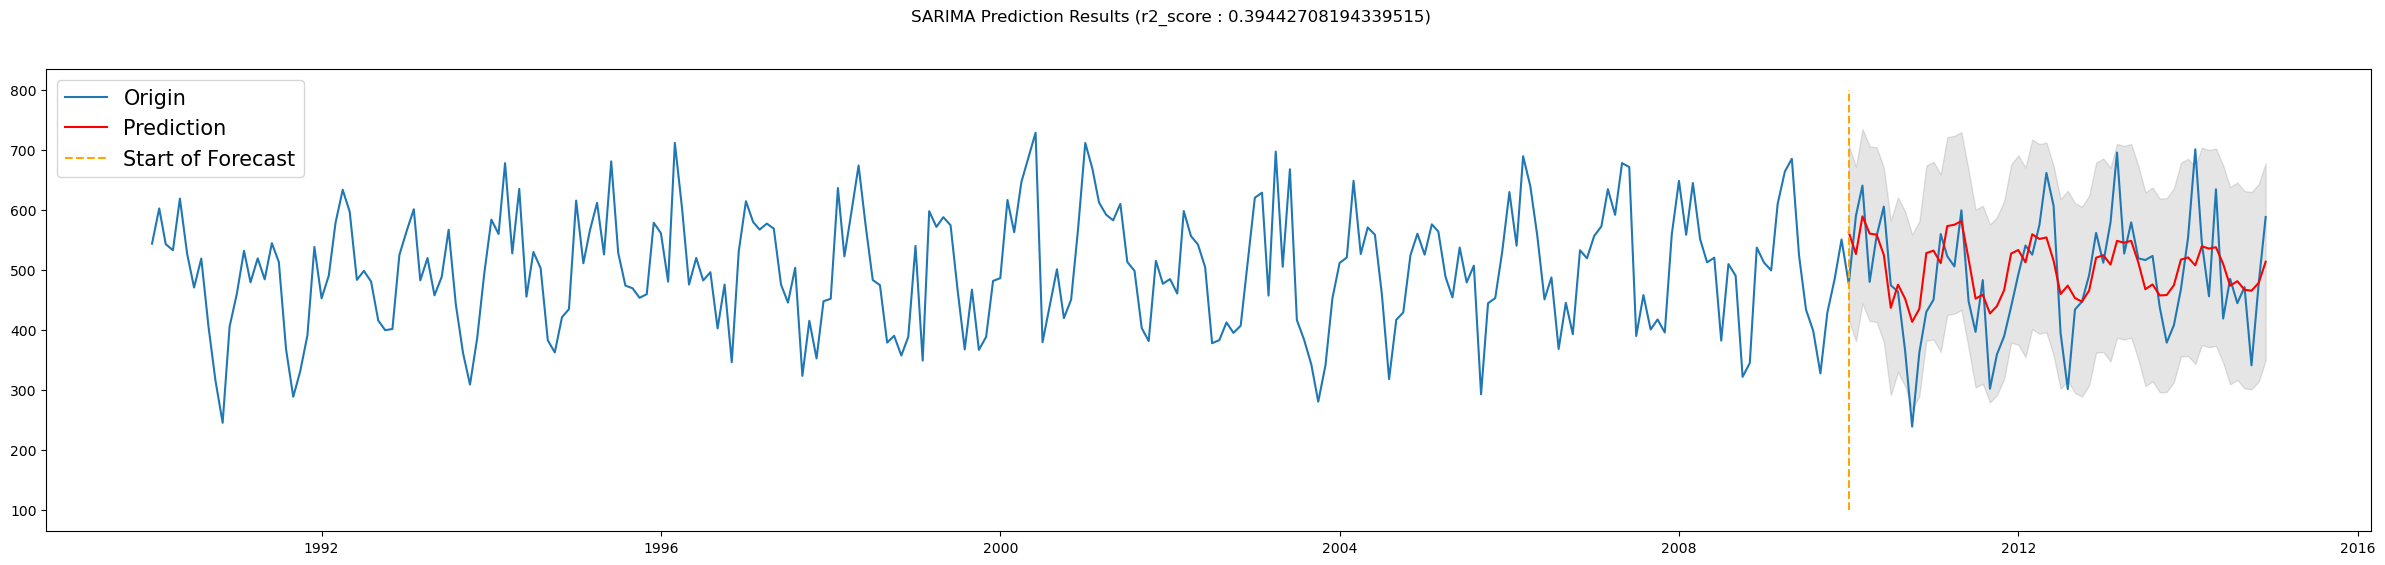

In [113]:
plt.figure(figsize=(30,6))

plt.plot(df_cub_interpol['impute_cub_interpol'], label='Origin')
plt.plot(auto_sarima_index, auto_sarima_pred_val, color='red', label='Prediction')

plt.fill_between(auto_sarima_index,
                auto_sarima_lb,
                auto_sarima_ub, color='k', alpha=.1)

plt.vlines(auto_sarima_index[0], 100, 800, 
           linestyle='--', color='orange', 
           label='Start of Forecast')  # 예측 시작점

plt.suptitle('SARIMA Prediction Results (r2_score : {0})'.format(r2_auto_sarima))
plt.legend(loc='upper left', fontsize=15)
plt.show()

In [114]:
# ARIMA => 평균 예측보다 못하다는 뜻 (음수)
r2_auto_arima

-1.1133000225516936

In [115]:
# SARIMA
r2_auto_sarima

0.39442708194339515

In [116]:
# ARIMA
rmse_(test_data.values.reshape(1,-1).flatten(), auto_arima_pred_val.values)

114.43666847515159

In [117]:
# SARIMA
rmse_(test_data.values.reshape(1,-1).flatten(), auto_sarima_pred_val.values)

60.578026462187395

## 2-4) 분석결과 활용 가능 여부에 대한 분석 전문가로서의 제안

- ARIMA 모델에 비해 계절성을 반영한 SARIMA 모델에서 성능이 더 뛰어났으므로 SARIMA 모델을 사용하는 것이 적절해 보인다.
- 하지만 상대적으로 결정계수가 낮고, RMSE가 높은 편이므로 절대적인 모델 성능은 좋지 않은 것으로 보인다. 
- 따라서 다른 모델 또는 다른 접근 방식을 고려하는 것이 좋을 수 있다. 
    - 예를 들어, 데이터 전처리 방법의 변경, 다른 모델의 사용 또는 변수 선택과 추가 등의 접근 방식을 고려한다.